In [2]:
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
import flwr as fl

from flwr.common.logger import log
from logging import WARNING
from typing import Dict, List, Optional, Tuple, Union

import tensorflow as tf
import numpy as np
import os
import random
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.utils import shuffle
from joblib import load

from models import resnet_model
from load_partition import load_partition
from data_quality import *
from FlowerClient import CifarClient
from GetClient import *
from resnet_model import build_ResNet
from node_selection import *
from ClientConfigurationStrategies import *

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

ModuleNotFoundError: No module named 'models'

In [8]:
import os
import sys
#sys.path.append('/Users/mattia.sabella/Development/Green-Federated-Learning-a-Data-Centric-Approach-in-the-Cloud-Continuum/')
print("Current Working Directory:", os.getcwd())

import joblib

print(sys.path)
load("/Users/mattia.sabella/Development/Green-Federated-Learning-a-Data-Centric-Approach-in-the-Cloud-Continuum/models/model.joblib")

Current Working Directory: /Users/mattia.sabella/Development/Green-Federated-Learning-a-Data-Centric-Approach-in-the-Cloud-Continuum/notebooks
['/Users/mattia.sabella/.pyenv/versions/3.12.9/lib/python312.zip', '/Users/mattia.sabella/.pyenv/versions/3.12.9/lib/python3.12', '/Users/mattia.sabella/.pyenv/versions/3.12.9/lib/python3.12/lib-dynload', '', '/Users/mattia.sabella/Development/Green-Federated-Learning-a-Data-Centric-Approach-in-the-Cloud-Continuum/.venv/lib/python3.12/site-packages']


ModuleNotFoundError: No module named 'sklearn.ensemble._gb_losses'

In [10]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Dataset to be validated

In [11]:
train_data = np.loadtxt(f".Datasets/Datasets_Validation/FreezerRegularTrain/FreezerRegularTrain_TRAIN.txt")
test_data = np.loadtxt(f".Datasets/Datasets_Validation/FreezerRegularTrain/FreezerRegularTrain_TEST.txt")

#Swap x_train and x_test because the test set is bigger
X_test = np.expand_dims(train_data[:, 1:],axis=-1)
y_test = train_data[:, 0]

X_train = np.expand_dims(test_data[:, 1:], axis=-1)
y_train = test_data[:, 0]

X_train, y_train = shuffle(X_train, y_train)


#Take the last 100 samples of x_train for the validation step
X_val = X_train[-100:]
y_val = y_train[-100:]
X_train = X_train[:-100]
y_train = y_train[:-100]


#Only for twoleadecg dataset
X_test = np.concatenate((X_test, X_train[-400:]), axis=0)
y_test = np.concatenate((y_test, y_train[-400:]), axis=0)
X_train = X_train[:-400]
y_train = y_train[:-400]


X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2350, 301, 1), (2350,), (100, 301, 1), (100,), (550, 301, 1), (550,))

# Dataset Split and Graphical Distribution

In [12]:
def splitting_dataset(dataset):
  file_path = 'data_nodes/data_nodes.json'
  with open(file_path, "r") as json_file:
    data = json.load(json_file)

  total_points = dataset.shape[0]
  indexes = []
  #Initialize with the first index
  indexes.append(0)
  for obj_exp in data:
    number_points = (int)(obj_exp['data_volume']*total_points)
    new_index = indexes[-1] + number_points
    indexes.append(new_index)

  return indexes

[0, 18, 28, 48, 60, 70, 80, 85, 90, 94, 100]


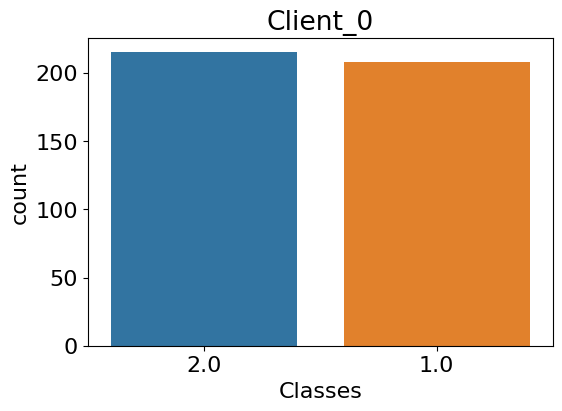

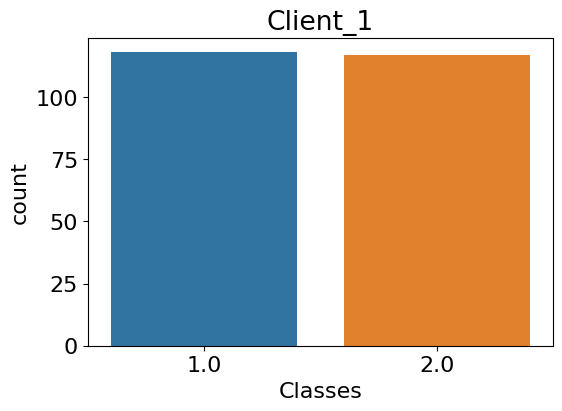

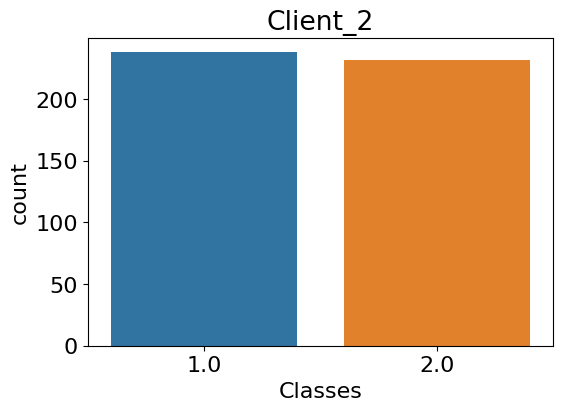

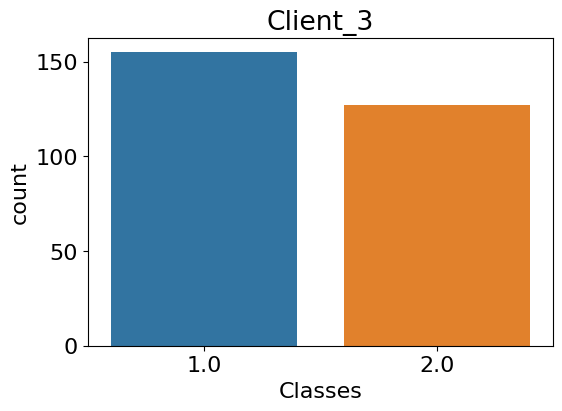

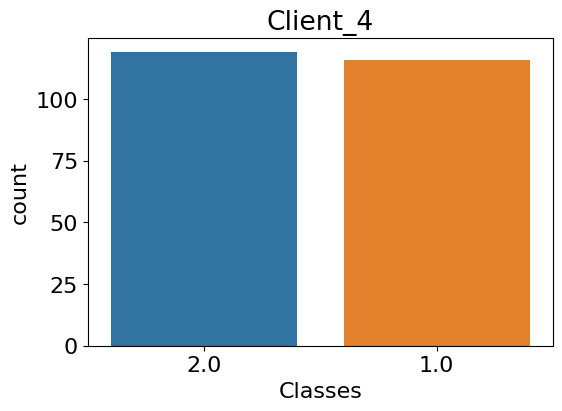

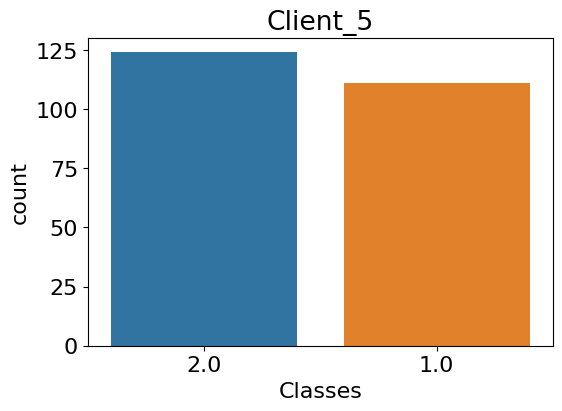

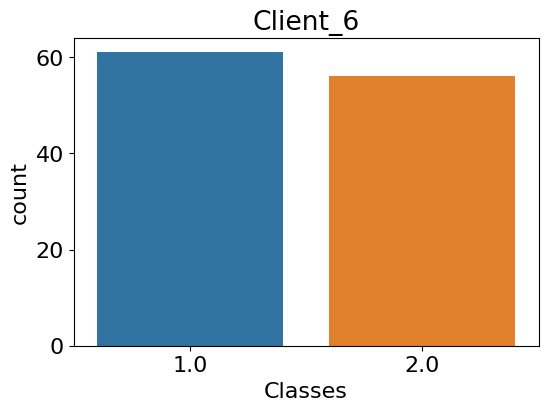

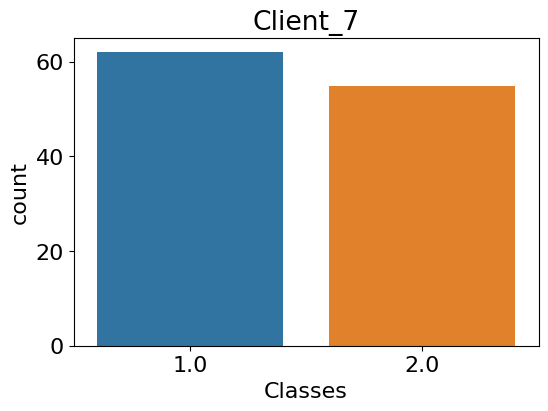

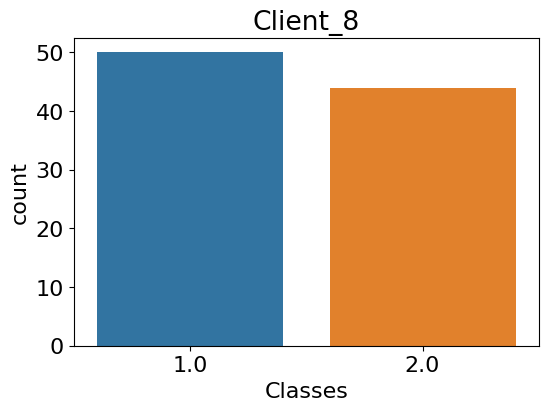

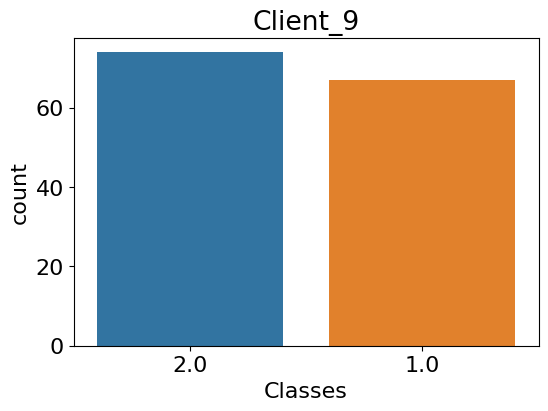

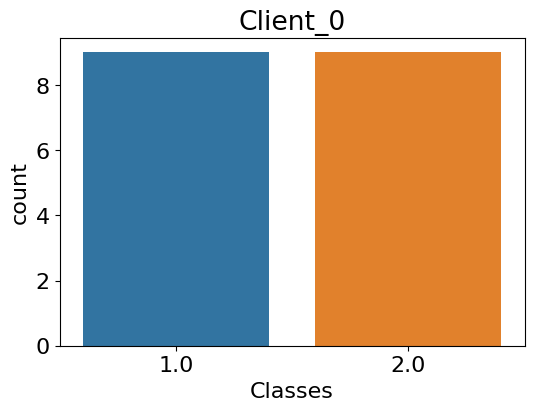

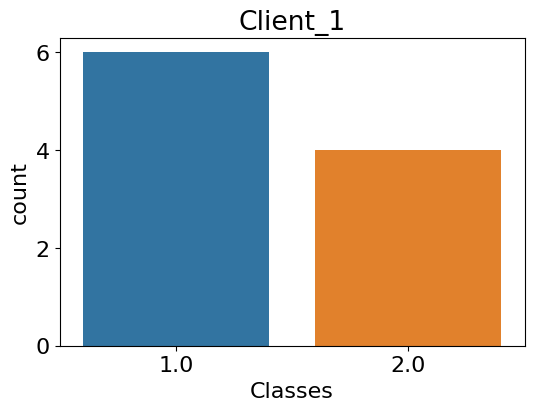

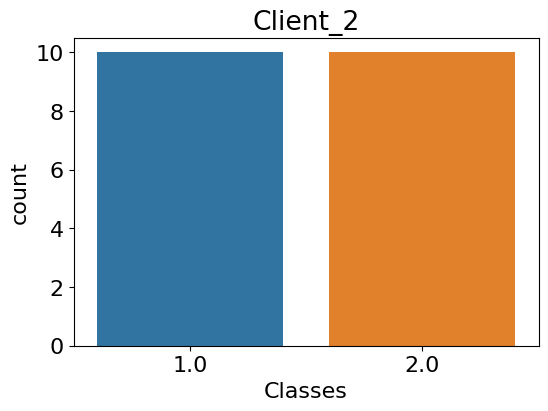

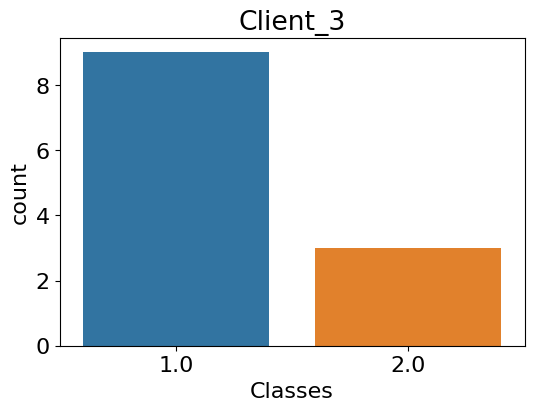

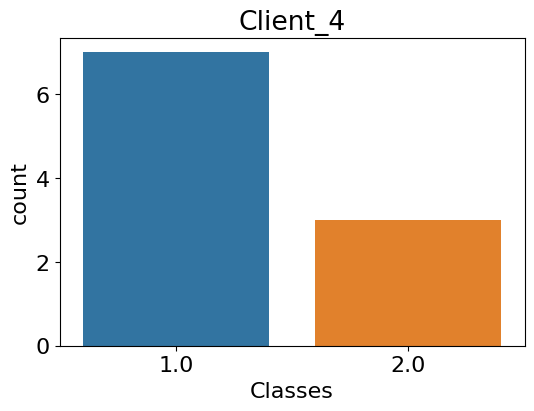

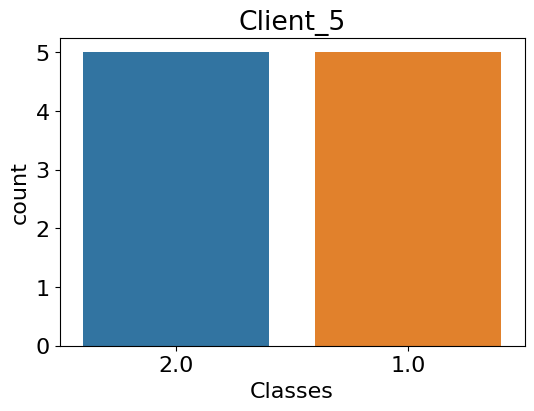

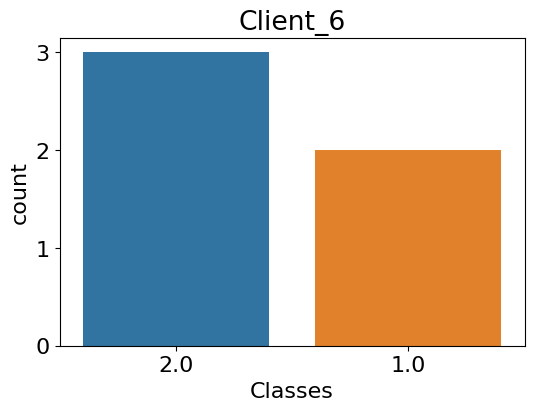

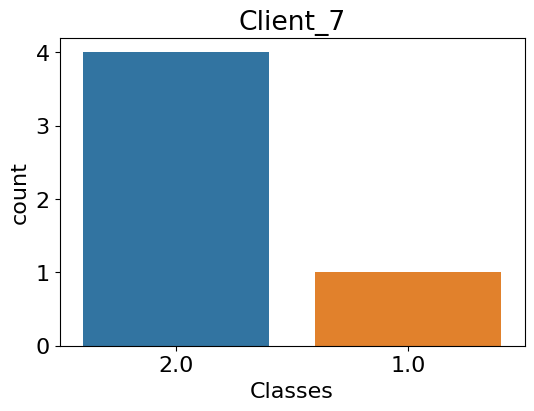

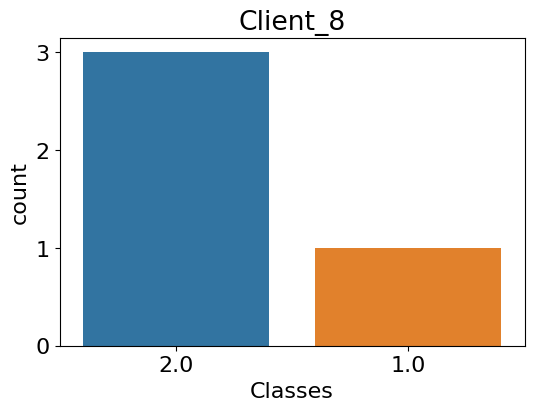

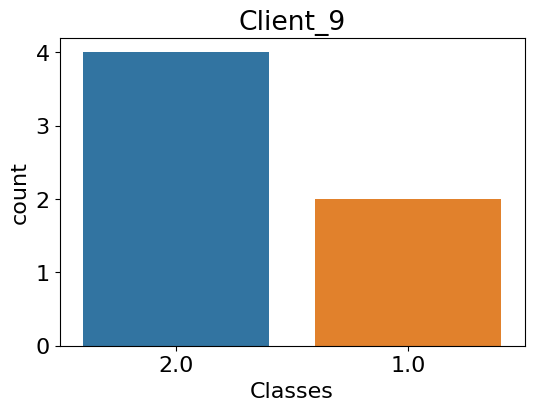

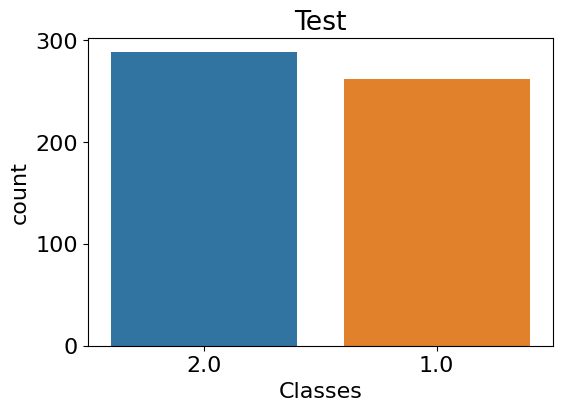

In [13]:
column_name = ["Classes"]
clients = 10

#Here I need to insert how the dataset is splitted
indexes_train = splitting_dataset(X_train)
indexes_val = splitting_dataset(X_val)

print(indexes_val)

for i in range(0,clients):
  start_index = indexes_train[i]
  end_index = indexes_train[i + 1]
  df = pd.DataFrame(y_train[start_index:end_index])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

for i in range(0,clients):
  start_index = indexes_val[i]
  end_index = indexes_val[i + 1]
  df = pd.DataFrame(y_val[start_index:end_index])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

df = pd.DataFrame(y_test)
df.columns = column_name

# Inspect activities timestamps
plt.figure(figsize=(6,4))
sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
plt.title(f'Test')
plt.show()

# Load Parameters and Partitioning

In [18]:
#This is done to poison the data points correctly
Y_TRAIN = y_train

# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

X_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = X_train, X_val, y_val, X_test, y_test

In [22]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 200

# First Simulation Full Resources (Baseline)

This simulation considers an infrastructure configuration of nodes (data_nodes_0.json) and all the clients nodes together with all their data available are considered for training

## Configuration Flower Client Full Resources

In [ ]:
def get_client_fn(nodes):
  # It must be called to create an instance of a new FlowerClient
  def client_fn(cid: str) -> CifarClient:
      """Create a Flower client representing a single organization."""

      # Note: each client gets a different trainloader/valloader, so each client
      # will train and evaluate on their own unique data
      print("Client with CID: {}\n".format(int(cid)))
      id = (int)(cid)
      # The volume in experiment of type Full Resources is 100%
      options_volume = {'data_quality_dimension_percentage': 1.0, 'experiment_method': 'uniform'}
      options_consistency = {'data_quality_dimension_percentage': nodes[id]['consistency'], 'experiment_method': 'uniform'}
      options_completeness = {'data_quality_dimension_percentage': nodes[id]['completeness'], 'experiment_method': 'uniform'}
      (x_train, y_train), (x_test, y_test) = load_partition(nodes[id]['id'], X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, indexes_train, indexes_val)

      #Data quality poisoning
      x_train, y_train = reduce_data_volume(x_train, y_train, options_volume)
      x_train, y_train = reduce_consistency(x_train, y_train, options_consistency)
      x_train, y_train = reduce_completeness(x_train, y_train, options_completeness)
      #This is just to take the right shape and build the model
      y_train = tfk.utils.to_categorical(y_train)

      # Load model
      model_client = build_ResNet(x_train.shape[1:], y_train.shape[-1])

      # Create a  single Flower client representing a single organization
      return CifarClient(cid, model_client, x_train, y_train, x_test, y_test, nodes[id]['energy_consumption'], nodes[id]['carbon_intensity'])
  return client_fn

## Simulation

In [ ]:
# Repeat the same experiment 3 times
for i in range(0,1):
  #Read data given in input
  file_path = 'data_nodes/data_nodes_0.json'

  with open(file_path, "r") as json_file:
      nodes = json.load(json_file)

  NUM_CLIENTS = len(nodes)
  FRACTION_FIT = 1.0
  NUM_SET_CLIENTS = len(nodes)

  #Define the path where to save the results
  file_path = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results.json'
  if not os.path.exists(file_path):
    options = [{'experiment_method': 'full_resources', 'data_volume': 1.0, 'num_clients': NUM_CLIENTS, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
    with open(file_path, "w") as json_file:
      json.dump(options, json_file)
  else:
    options = {'experiment_method': 'full_resources', 'data_volume': 1.0, 'num_clients': NUM_CLIENTS, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
    with open(file_path, "r") as json_file:
      data = json.load(json_file)
      data.append(options)
    with open(file_path, "w") as json_file:
      json.dump(data, json_file)

  new_model = build_ResNet(input_shape, classes)

  # Create strategy
  strategy_basic = CustomClientConfigStrategy_fixed(
      file_path = file_path,
      fraction_fit=FRACTION_FIT,
      fraction_evaluate=0.1,
      min_fit_clients=1,
      min_evaluate_clients=1,
      min_available_clients=NUM_CLIENTS,
      evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
      # on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
  )

  single_client_gpu_access = 1
  # Start simulation
  history = fl.simulation.start_simulation(
      client_fn=get_client_fn(nodes),
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=6),
      strategy=strategy_basic,
      #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
      client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
      actor_kwargs={
          "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
      }
  )

INFO flwr 2023-11-18 17:04:02,044 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-18 17:04:10,606	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-18 17:04:13,665 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 7902169499.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3951084748.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7902169499.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3951084748.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-11-18 17:04:13,675 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO flwr 2023-11-18 17:04:13,730 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-18 17:04:13,737 | server.py:89 | Initializing global parameters
INFO

18/18 [==============================] - 2s 14ms/step - loss: 1.1116 - accuracy: 0.0000e+00


INFO flwr 2023-11-18 17:04:16,473 | server.py:94 | initial parameters (loss, other metrics): 1.111588478088379, {'accuracy': 0.0}
INFO:flwr:initial parameters (loss, other metrics): 1.111588478088379, {'accuracy': 0.0}
INFO flwr 2023-11-18 17:04:16,478 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-18 17:04:16,483 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 10)


Round 1 will sample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']


(pid=59751) 2023-11-18 17:04:18.513608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 
(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon INFO @ 17:04:23] offline tracker init
(DefaultActor pid=59751) [codecarbon WARNING @ 17:04:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:04:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 17s 202ms/step - loss: 0.8169 - accuracy: 0.4770 - val_loss: 0.9407 - val_accuracy: 0.3607 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 49ms/step - loss: 0.7981 - accuracy: 0.5028 - val_loss: 0.9113 - val_accuracy: 0.3607 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 51ms/step - loss: 0.7200 - accuracy: 0.4972 - val_loss: 0.8310 - val_accuracy: 0.3607 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 41ms/step - loss: 0.7059 - accuracy: 0.5470 - val_loss: 0.8323 - val_accuracy: 0.3443 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 43ms/step - loss: 0.7165 - accuracy: 0.5599 - val_loss: 0.7602 - val_accuracy: 0.6393 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 41ms/step - loss: 0.713

(DefaultActor pid=59751) [codecarbon WARNING @ 17:05:00] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:05:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 94ms/step - loss: 0.8482 - accuracy: 0.5468 - val_loss: 0.9530 - val_accuracy: 0.6809 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.7173 - accuracy: 0.6043 - val_loss: 0.8989 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6808 - accuracy: 0.5923 - val_loss: 0.8443 - val_accuracy: 0.6170 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6899 - accuracy: 0.5971 - val_loss: 0.7981 - val_accuracy: 0.6596 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6767 - accuracy: 0.6139 - val_loss: 0.7538 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6568

(DefaultActor pid=59751) [codecarbon WARNING @ 17:05:30] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 51
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (515, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:05:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 226ms/step - loss: 0.8683 - accuracy: 0.4795 - val_loss: 0.9324 - val_accuracy: 0.6538 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 44ms/step - loss: 0.7050 - accuracy: 0.6156 - val_loss: 0.8325 - val_accuracy: 0.5577 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 52ms/step - loss: 0.6806 - accuracy: 0.5896 - val_loss: 0.7822 - val_accuracy: 0.4423 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6899 - accuracy: 0.5464 - val_loss: 0.7631 - val_accuracy: 0.4423 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6796 - accuracy: 0.5724 - val_loss: 0.7538 - val_accuracy: 0.4423 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 41ms/step - loss: 0.672

(DefaultActor pid=59751) [codecarbon WARNING @ 17:05:59] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:06:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 15s 91ms/step - loss: 0.7862 - accuracy: 0.5475 - val_loss: 0.9171 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.7306 - accuracy: 0.6225 - val_loss: 0.8265 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6943 - accuracy: 0.6050 - val_loss: 0.7739 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6818 - accuracy: 0.5675 - val_loss: 0.7487 - val_accuracy: 0.5778 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6650 - accuracy: 0.6375 - val_loss: 0.7433 - val_accuracy: 0.5111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 34ms/step - loss: 0.6603

(DefaultActor pid=59751) [codecarbon WARNING @ 17:06:28] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:06:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 91ms/step - loss: 0.7779 - accuracy: 0.6000 - val_loss: 0.8657 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.5682 - accuracy: 0.7125 - val_loss: 0.7734 - val_accuracy: 0.6889 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.5175 - accuracy: 0.7750 - val_loss: 0.7618 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.4119 - accuracy: 0.8425 - val_loss: 0.7457 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 34ms/step - loss: 0.5381 - accuracy: 0.7800 - val_loss: 0.9911 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.4838

(DefaultActor pid=59751) [codecarbon WARNING @ 17:06:58] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 45
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (454, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:07:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 133ms/step - loss: 0.8373 - accuracy: 0.5735 - val_loss: 0.9304 - val_accuracy: 0.5652 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 40ms/step - loss: 0.6587 - accuracy: 0.6740 - val_loss: 0.7957 - val_accuracy: 0.6739 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6179 - accuracy: 0.6765 - val_loss: 0.7286 - val_accuracy: 0.6304 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5839 - accuracy: 0.7059 - val_loss: 0.7393 - val_accuracy: 0.6957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5444 - accuracy: 0.7328 - val_loss: 0.7835 - val_accuracy: 0.5652 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.500

(DefaultActor pid=59751) [codecarbon WARNING @ 17:07:27] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 43
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (431, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:07:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 12s 132ms/step - loss: 0.7019 - accuracy: 0.6589 - val_loss: 0.9449 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 51ms/step - loss: 0.4927 - accuracy: 0.7804 - val_loss: 0.8987 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 37ms/step - loss: 0.3992 - accuracy: 0.8450 - val_loss: 0.9163 - val_accuracy: 0.3409 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 41ms/step - loss: 0.3181 - accuracy: 0.8992 - val_loss: 0.8152 - val_accuracy: 0.5909 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 36ms/step - loss: 0.2253 - accuracy: 0.9302 - val_loss: 0.8253 - val_accuracy: 0.5909 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 41ms/step - loss: 0.1716 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:07:55] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 47
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (470, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:07:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 14s 103ms/step - loss: 0.8179 - accuracy: 0.5508 - val_loss: 0.9304 - val_accuracy: 0.7234 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.6495 - accuracy: 0.6761 - val_loss: 0.8456 - val_accuracy: 0.6170 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 38ms/step - loss: 0.6285 - accuracy: 0.6738 - val_loss: 0.8051 - val_accuracy: 0.5106 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 35ms/step - loss: 0.6034 - accuracy: 0.7281 - val_loss: 0.8167 - val_accuracy: 0.4468 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 39ms/step - loss: 0.5997 - accuracy: 0.6974 - val_loss: 0.7931 - val_accuracy: 0.2979 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 34ms/step - loss: 0.5477 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:08:24] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:08:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 128ms/step - loss: 0.8017 - accuracy: 0.5538 - val_loss: 0.9059 - val_accuracy: 0.5102 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6963 - accuracy: 0.6407 - val_loss: 0.8086 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.7182 - accuracy: 0.5995 - val_loss: 0.7722 - val_accuracy: 0.6327 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.6720 - accuracy: 0.6476 - val_loss: 0.7757 - val_accuracy: 0.4898 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6515 - accuracy: 0.6476 - val_loss: 0.7681 - val_accuracy: 0.4898 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 36ms/step - loss: 0.665

(DefaultActor pid=59751) [codecarbon WARNING @ 17:08:57] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 54
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (542, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:08:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 156ms/step - loss: 0.8334 - accuracy: 0.5031 - val_loss: 0.9325 - val_accuracy: 0.5636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 46ms/step - loss: 0.7327 - accuracy: 0.5524 - val_loss: 0.8320 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 46ms/step - loss: 0.6863 - accuracy: 0.5626 - val_loss: 0.7904 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 1s 54ms/step - loss: 0.7077 - accuracy: 0.5749 - val_loss: 0.7890 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 46ms/step - loss: 0.6740 - accuracy: 0.6386 - val_loss: 0.7731 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 47ms/step - loss: 0.707

DEBUG flwr 2023-11-18 17:09:28,081 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-18 17:09:28,231 | <ipython-input-26-bc404921f141>:97 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=59751) {'effective_epochs': 40, 'effective_emissions_kg': 0.059, 'effective_energy_consumed': 0.028, 'effective_duration': 28.813156366348267}
18/18 [==============================] - 0s 8ms/step - loss: 0.7127 - accuracy: 0.5236


INFO flwr 2023-11-18 17:09:28,507 | server.py:125 | fit progress: (1, 0.7126638293266296, {'accuracy': 0.5236363410949707}, 312.0243779819998)
INFO:flwr:fit progress: (1, 0.7126638293266296, {'accuracy': 0.5236363410949707}, 312.0243779819998)
DEBUG flwr 2023-11-18 17:09:28,515 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 
1/3 [=========>....................] - ETA: 1s - loss: 0.7220 - accuracy: 0.5000


DEBUG flwr 2023-11-18 17:09:30,219 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2023-11-18 17:09:30,224 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-18 17:09:30,226 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)
(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 2 will resample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']
3/3 [==============================] - 1s 150ms/step - loss: 0.7220 - accuracy: 0.5000
(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 
(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:09:30] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:09:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 173ms/step - loss: 0.7360 - accuracy: 0.4917 - val_loss: 0.7384 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 43ms/step - loss: 0.7053 - accuracy: 0.5230 - val_loss: 0.7335 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6912 - accuracy: 0.5562 - val_loss: 0.7264 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 47ms/step - loss: 0.6967 - accuracy: 0.5120 - val_loss: 0.7095 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6849 - accuracy: 0.5525 - val_loss: 0.7106 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.700

(DefaultActor pid=59751) [codecarbon WARNING @ 17:10:02] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:10:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 96ms/step - loss: 0.6737 - accuracy: 0.6475 - val_loss: 0.7006 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5865 - accuracy: 0.7458 - val_loss: 0.6910 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6012 - accuracy: 0.7506 - val_loss: 0.6997 - val_accuracy: 0.5532 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.5857 - accuracy: 0.7410 - val_loss: 0.6929 - val_accuracy: 0.5532 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5614 - accuracy: 0.7602 - val_loss: 0.7075 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6045

(DefaultActor pid=59751) [codecarbon WARNING @ 17:10:31] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 51
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (515, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:10:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 126ms/step - loss: 0.6610 - accuracy: 0.6479 - val_loss: 0.7381 - val_accuracy: 0.4808 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 0.6433 - accuracy: 0.6803 - val_loss: 0.7296 - val_accuracy: 0.4808 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 0.6542 - accuracy: 0.6566 - val_loss: 0.7202 - val_accuracy: 0.5192 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6468 - accuracy: 0.6523 - val_loss: 0.7114 - val_accuracy: 0.5192 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 49ms/step - loss: 0.6184 - accuracy: 0.7063 - val_loss: 0.7121 - val_accuracy: 0.5192 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.621

(DefaultActor pid=59751) [codecarbon WARNING @ 17:11:00] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:11:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 15s 94ms/step - loss: 0.7010 - accuracy: 0.5700 - val_loss: 0.6965 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 33ms/step - loss: 0.6719 - accuracy: 0.6000 - val_loss: 0.7250 - val_accuracy: 0.3778 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6722 - accuracy: 0.6175 - val_loss: 0.6880 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.6545 - accuracy: 0.6175 - val_loss: 0.6754 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6624 - accuracy: 0.6175 - val_loss: 0.6659 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 37ms/step - loss: 0.6583

(DefaultActor pid=59751) [codecarbon WARNING @ 17:11:31] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:11:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 91ms/step - loss: 0.4046 - accuracy: 0.8575 - val_loss: 0.7035 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.4045 - accuracy: 0.8725 - val_loss: 0.6955 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.3650 - accuracy: 0.8975 - val_loss: 0.7244 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 37ms/step - loss: 0.3160 - accuracy: 0.9050 - val_loss: 0.6787 - val_accuracy: 0.6444 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.3152 - accuracy: 0.9125 - val_loss: 0.6771 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 35ms/step - loss: 0.3036

(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:01] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 10s 126ms/step - loss: 0.4213 - accuracy: 0.8652 - val_loss: 0.7495 - val_accuracy: 0.4565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.4307 - accuracy: 0.8627 - val_loss: 0.7540 - val_accuracy: 0.4565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 40ms/step - loss: 0.3617 - accuracy: 0.8799 - val_loss: 0.7461 - val_accuracy: 0.4565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.3991 - accuracy: 0.8701 - val_loss: 0.7073 - val_accuracy: 0.4565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 40ms/step - loss: 0.3475 - accuracy: 0.8946 - val_loss: 0.7751 - val_accuracy: 0.4565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 39ms/step - loss: 0.333

(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:29] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 43
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (431, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 14s 161ms/step - loss: 0.3223 - accuracy: 0.8966 - val_loss: 0.7877 - val_accuracy: 0.3864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 39ms/step - loss: 0.2054 - accuracy: 0.9509 - val_loss: 0.8239 - val_accuracy: 0.3864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 45ms/step - loss: 0.2070 - accuracy: 0.9561 - val_loss: 0.7852 - val_accuracy: 0.3864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 43ms/step - loss: 0.2024 - accuracy: 0.9509 - val_loss: 0.7750 - val_accuracy: 0.3864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 44ms/step - loss: 0.1952 - accuracy: 0.9561 - val_loss: 0.7697 - val_accuracy: 0.3864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 38ms/step - loss: 0.1755 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:57] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 47
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (470, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:12:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 13s 104ms/step - loss: 0.6019 - accuracy: 0.7187 - val_loss: 0.7413 - val_accuracy: 0.4681 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.5707 - accuracy: 0.7470 - val_loss: 0.7324 - val_accuracy: 0.4681 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 34ms/step - loss: 0.5611 - accuracy: 0.7636 - val_loss: 0.7497 - val_accuracy: 0.4681 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 37ms/step - loss: 0.5415 - accuracy: 0.7707 - val_loss: 0.7332 - val_accuracy: 0.4681 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 35ms/step - loss: 0.5394 - accuracy: 0.7825 - val_loss: 0.7330 - val_accuracy: 0.4681 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 37ms/step - loss: 0.5447 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:13:27] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 48
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (486, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:13:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 99ms/step - loss: 0.6002 - accuracy: 0.7391 - val_loss: 0.6967 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5983 - accuracy: 0.7483 - val_loss: 0.7057 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5659 - accuracy: 0.7346 - val_loss: 0.7087 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5564 - accuracy: 0.7666 - val_loss: 0.6953 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5687 - accuracy: 0.7666 - val_loss: 0.6952 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5545

(DefaultActor pid=59751) [codecarbon WARNING @ 17:13:57] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 54
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (542, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:13:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 219ms/step - loss: 0.7362 - accuracy: 0.5380 - val_loss: 0.7281 - val_accuracy: 0.5091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6937 - accuracy: 0.5441 - val_loss: 0.6947 - val_accuracy: 0.6182 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6777 - accuracy: 0.5811 - val_loss: 0.7156 - val_accuracy: 0.5091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6770 - accuracy: 0.5626 - val_loss: 0.7119 - val_accuracy: 0.5091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 1s 53ms/step - loss: 0.7038 - accuracy: 0.5462 - val_loss: 0.7068 - val_accuracy: 0.5091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 46ms/step - loss: 0.692

DEBUG flwr 2023-11-18 17:14:29,093 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


(DefaultActor pid=59751) {'effective_epochs': 40, 'effective_emissions_kg': 0.061, 'effective_energy_consumed': 0.029, 'effective_duration': 29.609644889831543}
18/18 [==============================] - 0s 9ms/step - loss: 0.4935 - accuracy: 0.9964


INFO flwr 2023-11-18 17:14:29,663 | server.py:125 | fit progress: (2, 0.4934595823287964, {'accuracy': 0.996363639831543}, 613.1804697170005)
INFO:flwr:fit progress: (2, 0.4934595823287964, {'accuracy': 0.996363639831543}, 613.1804697170005)
DEBUG flwr 2023-11-18 17:14:29,668 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 


DEBUG flwr 2023-11-18 17:14:30,916 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-11-18 17:14:30,922 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)
(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 3 will resample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']
3/3 [==============================] - 1s 9ms/step - loss: 0.5186 - accuracy: 1.0000
(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 


(DefaultActor pid=59751) [codecarbon WARNING @ 17:14:31] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:14:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 104ms/step - loss: 0.7477 - accuracy: 0.5414 - val_loss: 0.7595 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6957 - accuracy: 0.5028 - val_loss: 0.8158 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6985 - accuracy: 0.5359 - val_loss: 0.7477 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6955 - accuracy: 0.5230 - val_loss: 0.7139 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6879 - accuracy: 0.5506 - val_loss: 0.7079 - val_accuracy: 0.4590 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.683

(DefaultActor pid=59751) [codecarbon WARNING @ 17:15:06] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:15:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 229ms/step - loss: 0.5973 - accuracy: 0.7386 - val_loss: 0.5500 - val_accuracy: 0.8298 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 44ms/step - loss: 0.5900 - accuracy: 0.7146 - val_loss: 0.5773 - val_accuracy: 0.8298 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.5712 - accuracy: 0.7338 - val_loss: 2.5643 - val_accuracy: 0.5319 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 51ms/step - loss: 0.7210 - accuracy: 0.6954 - val_loss: 2.4443 - val_accuracy: 0.5319 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.6199 - accuracy: 0.7146 - val_loss: 1.1161 - val_accuracy: 0.5319 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.605

(DefaultActor pid=59751) [codecarbon WARNING @ 17:15:35] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 51
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (515, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:15:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 155ms/step - loss: 0.6218 - accuracy: 0.7041 - val_loss: 0.6632 - val_accuracy: 0.4615 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 46ms/step - loss: 0.5935 - accuracy: 0.7235 - val_loss: 0.6194 - val_accuracy: 0.7115 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 0.5869 - accuracy: 0.7127 - val_loss: 0.6568 - val_accuracy: 0.4615 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 41ms/step - loss: 0.5840 - accuracy: 0.7235 - val_loss: 0.7962 - val_accuracy: 0.4615 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 42ms/step - loss: 0.5736 - accuracy: 0.7300 - val_loss: 0.6938 - val_accuracy: 0.5385 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 1s 52ms/step - loss: 0.572

(DefaultActor pid=59751) [codecarbon WARNING @ 17:16:07] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:16:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 91ms/step - loss: 0.6577 - accuracy: 0.6800 - val_loss: 1.6750 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6628 - accuracy: 0.5750 - val_loss: 0.7993 - val_accuracy: 0.4222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.6207 - accuracy: 0.6975 - val_loss: 1.4135 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6269 - accuracy: 0.7050 - val_loss: 0.5943 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.6228 - accuracy: 0.6825 - val_loss: 0.5420 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 33ms/step - loss: 0.6331

(DefaultActor pid=59751) [codecarbon WARNING @ 17:16:36] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:16:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 121ms/step - loss: 0.3585 - accuracy: 0.8950 - val_loss: 0.6740 - val_accuracy: 0.4889 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 39ms/step - loss: 0.3591 - accuracy: 0.8850 - val_loss: 1.9354 - val_accuracy: 0.5111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 55ms/step - loss: 0.3337 - accuracy: 0.8925 - val_loss: 0.5556 - val_accuracy: 0.8667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3788 - accuracy: 0.8875 - val_loss: 0.5458 - val_accuracy: 0.7556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 40ms/step - loss: 0.3385 - accuracy: 0.9025 - val_loss: 0.4210 - val_accuracy: 0.8667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.322

(DefaultActor pid=59751) [codecarbon WARNING @ 17:17:05] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 45
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (454, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:17:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 128ms/step - loss: 0.3740 - accuracy: 0.8897 - val_loss: 0.5999 - val_accuracy: 0.7391 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.3420 - accuracy: 0.8676 - val_loss: 0.7460 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.4447 - accuracy: 0.8578 - val_loss: 0.7895 - val_accuracy: 0.7609 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 42ms/step - loss: 0.3549 - accuracy: 0.8897 - val_loss: 0.3192 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.3479 - accuracy: 0.8873 - val_loss: 0.5736 - val_accuracy: 0.6304 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 39ms/step - loss: 0.331

(DefaultActor pid=59751) [codecarbon WARNING @ 17:17:34] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 43
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (431, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:17:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 14s 149ms/step - loss: 0.1735 - accuracy: 0.9664 - val_loss: 0.4649 - val_accuracy: 0.9091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 39ms/step - loss: 0.1497 - accuracy: 0.9664 - val_loss: 0.4712 - val_accuracy: 0.8409 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 36ms/step - loss: 0.1376 - accuracy: 0.9690 - val_loss: 0.3032 - val_accuracy: 0.9545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1659 - accuracy: 0.9612 - val_loss: 0.4169 - val_accuracy: 0.8864 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 36ms/step - loss: 0.1444 - accuracy: 0.9664 - val_loss: 0.2279 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 33ms/step - loss: 0.1404 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:18:03] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 47
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (470, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:18:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 13s 105ms/step - loss: 0.5445 - accuracy: 0.7872 - val_loss: 0.6583 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 35ms/step - loss: 0.5189 - accuracy: 0.8085 - val_loss: 0.8978 - val_accuracy: 0.6383 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 37ms/step - loss: 0.5301 - accuracy: 0.7730 - val_loss: 0.6530 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 35ms/step - loss: 0.4963 - accuracy: 0.8038 - val_loss: 0.6955 - val_accuracy: 0.6596 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 35ms/step - loss: 0.4859 - accuracy: 0.8180 - val_loss: 0.7101 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 35ms/step - loss: 0.4774 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:18:33] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:18:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 96ms/step - loss: 0.5726 - accuracy: 0.7460 - val_loss: 0.6139 - val_accuracy: 0.6735 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.5726 - accuracy: 0.7574 - val_loss: 0.6699 - val_accuracy: 0.5102 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 0.5495 - accuracy: 0.7735 - val_loss: 0.5910 - val_accuracy: 0.7551 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 1s 53ms/step - loss: 0.5565 - accuracy: 0.7597 - val_loss: 0.5898 - val_accuracy: 0.7347 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.5397 - accuracy: 0.7689 - val_loss: 0.6585 - val_accuracy: 0.6735 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 42ms/step - loss: 0.5531

(DefaultActor pid=59751) [codecarbon WARNING @ 17:19:00] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 54
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (542, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:19:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 238ms/step - loss: 0.6667 - accuracy: 0.6181 - val_loss: 0.6460 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 1s 68ms/step - loss: 0.6510 - accuracy: 0.6407 - val_loss: 0.8479 - val_accuracy: 0.6182 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6403 - accuracy: 0.6612 - val_loss: 1.2466 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 46ms/step - loss: 0.6318 - accuracy: 0.6735 - val_loss: 1.1321 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6405 - accuracy: 0.6591 - val_loss: 0.7195 - val_accuracy: 0.5273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.640

DEBUG flwr 2023-11-18 17:19:30,475 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


(DefaultActor pid=59751) {'effective_epochs': 37, 'effective_emissions_kg': 0.057, 'effective_energy_consumed': 0.027, 'effective_duration': 27.70583486557007}
18/18 [==============================] - 0s 9ms/step - loss: 0.3198 - accuracy: 0.9891


INFO flwr 2023-11-18 17:19:30,927 | server.py:125 | fit progress: (3, 0.31977570056915283, {'accuracy': 0.9890909194946289}, 914.4445406669997)
INFO:flwr:fit progress: (3, 0.31977570056915283, {'accuracy': 0.9890909194946289}, 914.4445406669997)
DEBUG flwr 2023-11-18 17:19:30,932 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 1
(DefaultActor pid=59751) 


DEBUG flwr 2023-11-18 17:19:32,313 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-11-18 17:19:32,324 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)
(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 4 will resample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']
3/3 [==============================] - 1s 9ms/step - loss: 0.3415 - accuracy: 1.0000
(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 


(DefaultActor pid=59751) [codecarbon WARNING @ 17:19:32] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:19:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 104ms/step - loss: 0.7029 - accuracy: 0.6059 - val_loss: 0.9499 - val_accuracy: 0.4426 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6969 - accuracy: 0.5322 - val_loss: 0.8221 - val_accuracy: 0.4426 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6752 - accuracy: 0.5838 - val_loss: 0.7502 - val_accuracy: 0.5246 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 45ms/step - loss: 0.6775 - accuracy: 0.5893 - val_loss: 0.7717 - val_accuracy: 0.5574 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6706 - accuracy: 0.6133 - val_loss: 0.7541 - val_accuracy: 0.4754 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 42ms/step - loss: 0.669

(DefaultActor pid=59751) [codecarbon WARNING @ 17:20:02] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 46
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (464, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:20:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 12s 97ms/step - loss: 0.5843 - accuracy: 0.7290 - val_loss: 1.9204 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6018 - accuracy: 0.7026 - val_loss: 0.6657 - val_accuracy: 0.6383 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.5894 - accuracy: 0.7290 - val_loss: 0.7252 - val_accuracy: 0.4468 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.5916 - accuracy: 0.7122 - val_loss: 1.4242 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.5700 - accuracy: 0.7266 - val_loss: 2.0984 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 35ms/step - loss: 0.5894

(DefaultActor pid=59751) [codecarbon WARNING @ 17:20:32] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:20:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 138ms/step - loss: 0.6059 - accuracy: 0.7084 - val_loss: 0.7017 - val_accuracy: 0.5577 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.5944 - accuracy: 0.7343 - val_loss: 0.6214 - val_accuracy: 0.7115 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5839 - accuracy: 0.7430 - val_loss: 0.6382 - val_accuracy: 0.7308 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5711 - accuracy: 0.7451 - val_loss: 0.6315 - val_accuracy: 0.6538 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5659 - accuracy: 0.7516 - val_loss: 0.6379 - val_accuracy: 0.6538 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 1s 54ms/step - loss: 0.569

(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:00] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 133ms/step - loss: 0.6672 - accuracy: 0.6275 - val_loss: 0.5757 - val_accuracy: 0.7333 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6742 - accuracy: 0.6150 - val_loss: 0.8214 - val_accuracy: 0.7333 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.6615 - accuracy: 0.6275 - val_loss: 0.5778 - val_accuracy: 0.6889 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 40ms/step - loss: 0.6421 - accuracy: 0.6575 - val_loss: 0.5955 - val_accuracy: 0.7111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 39ms/step - loss: 0.6439 - accuracy: 0.6725 - val_loss: 0.7015 - val_accuracy: 0.7111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 37ms/step - loss: 0.629

(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:24] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 144ms/step - loss: 0.3644 - accuracy: 0.8900 - val_loss: 0.6035 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 0.3290 - accuracy: 0.9075 - val_loss: 0.5340 - val_accuracy: 0.8222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3287 - accuracy: 0.9025 - val_loss: 0.4517 - val_accuracy: 0.8667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 38ms/step - loss: 0.3080 - accuracy: 0.9100 - val_loss: 0.5439 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 39ms/step - loss: 0.3299 - accuracy: 0.8975 - val_loss: 0.5239 - val_accuracy: 0.7111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 49ms/step - loss: 0.320

(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:54] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:21:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 97ms/step - loss: 0.4188 - accuracy: 0.8750 - val_loss: 0.5492 - val_accuracy: 0.6304 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.4177 - accuracy: 0.8627 - val_loss: 0.7630 - val_accuracy: 0.4348 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 35ms/step - loss: 0.4242 - accuracy: 0.8725 - val_loss: 1.1591 - val_accuracy: 0.7609 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 36ms/step - loss: 0.4023 - accuracy: 0.8750 - val_loss: 0.6335 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.4031 - accuracy: 0.8725 - val_loss: 0.4855 - val_accuracy: 0.7609 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 35ms/step - loss: 0.4065

(DefaultActor pid=59751) [codecarbon WARNING @ 17:22:27] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:22:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 10s 103ms/step - loss: 0.2135 - accuracy: 0.9561 - val_loss: 0.2795 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.1858 - accuracy: 0.9612 - val_loss: 0.2949 - val_accuracy: 0.9318 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 36ms/step - loss: 0.1777 - accuracy: 0.9612 - val_loss: 0.2311 - val_accuracy: 0.9545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1794 - accuracy: 0.9638 - val_loss: 0.8808 - val_accuracy: 0.6818 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 32ms/step - loss: 0.1866 - accuracy: 0.9561 - val_loss: 0.5356 - val_accuracy: 0.7273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 33ms/step - loss: 0.1696 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:22:53] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:22:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 12s 138ms/step - loss: 0.5131 - accuracy: 0.8014 - val_loss: 1.4206 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 54ms/step - loss: 0.4931 - accuracy: 0.7991 - val_loss: 0.5450 - val_accuracy: 0.8723 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 41ms/step - loss: 0.4908 - accuracy: 0.8061 - val_loss: 0.5172 - val_accuracy: 0.8723 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 44ms/step - loss: 0.4898 - accuracy: 0.7967 - val_loss: 0.5126 - val_accuracy: 0.7447 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 37ms/step - loss: 0.4828 - accuracy: 0.7991 - val_loss: 0.8366 - val_accuracy: 0.5532 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 37ms/step - loss: 0.4926 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:23:22] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:23:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 132ms/step - loss: 0.5618 - accuracy: 0.7872 - val_loss: 6.0846 - val_accuracy: 0.3673 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 43ms/step - loss: 0.5353 - accuracy: 0.7895 - val_loss: 0.5668 - val_accuracy: 0.7551 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5302 - accuracy: 0.7941 - val_loss: 0.6334 - val_accuracy: 0.6939 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 44ms/step - loss: 0.5321 - accuracy: 0.7803 - val_loss: 0.5589 - val_accuracy: 0.6939 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 51ms/step - loss: 0.5121 - accuracy: 0.7941 - val_loss: 0.6115 - val_accuracy: 0.7347 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 42ms/step - loss: 0.515

(DefaultActor pid=59751) [codecarbon WARNING @ 17:23:51] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 54
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (542, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:23:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 97ms/step - loss: 0.6653 - accuracy: 0.6509 - val_loss: 0.7280 - val_accuracy: 0.5636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 40ms/step - loss: 0.6663 - accuracy: 0.6448 - val_loss: 0.7000 - val_accuracy: 0.5636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 40ms/step - loss: 0.6467 - accuracy: 0.6694 - val_loss: 1.4854 - val_accuracy: 0.5273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.6402 - accuracy: 0.6674 - val_loss: 1.5336 - val_accuracy: 0.5273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6343 - accuracy: 0.6674 - val_loss: 1.3424 - val_accuracy: 0.5273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6470

DEBUG flwr 2023-11-18 17:24:24,513 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


(DefaultActor pid=59751) {'effective_epochs': 37, 'effective_emissions_kg': 0.063, 'effective_energy_consumed': 0.03, 'effective_duration': 30.786468505859375}
18/18 [==============================] - 0s 10ms/step - loss: 0.3126 - accuracy: 0.9982


INFO flwr 2023-11-18 17:24:25,197 | server.py:125 | fit progress: (4, 0.3126092553138733, {'accuracy': 0.9981818199157715}, 1208.714248916)
INFO:flwr:fit progress: (4, 0.3126092553138733, {'accuracy': 0.9981818199157715}, 1208.714248916)
DEBUG flwr 2023-11-18 17:24:25,201 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 5
(DefaultActor pid=59751) 


DEBUG flwr 2023-11-18 17:24:27,381 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-11-18 17:24:27,384 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)
(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


Round 5 will resample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']
5/5 [==============================] - 1s 9ms/step - loss: 0.3218 - accuracy: 1.0000
(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 
(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:24:28] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:24:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 146ms/step - loss: 0.7311 - accuracy: 0.5304 - val_loss: 0.8465 - val_accuracy: 0.5082 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 47ms/step - loss: 0.7079 - accuracy: 0.5359 - val_loss: 1.7592 - val_accuracy: 0.5082 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 64ms/step - loss: 0.6892 - accuracy: 0.5341 - val_loss: 0.9683 - val_accuracy: 0.5082 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 48ms/step - loss: 0.6867 - accuracy: 0.5451 - val_loss: 1.2454 - val_accuracy: 0.5082 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 47ms/step - loss: 0.6917 - accuracy: 0.5304 - val_loss: 1.0990 - val_accuracy: 0.5082 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 50ms/step - loss: 0.679

(DefaultActor pid=59751) [codecarbon WARNING @ 17:24:56] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 46
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (464, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:24:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 128ms/step - loss: 0.6036 - accuracy: 0.7170 - val_loss: 0.5990 - val_accuracy: 0.6809 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.5877 - accuracy: 0.7338 - val_loss: 0.7426 - val_accuracy: 0.5106 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.5812 - accuracy: 0.7338 - val_loss: 0.5762 - val_accuracy: 0.7447 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5786 - accuracy: 0.7338 - val_loss: 0.6538 - val_accuracy: 0.5745 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 1s 56ms/step - loss: 0.5773 - accuracy: 0.7434 - val_loss: 0.5367 - val_accuracy: 0.7660 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 40ms/step - loss: 0.572

(DefaultActor pid=59751) [codecarbon WARNING @ 17:25:25] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:25:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 15s 105ms/step - loss: 0.6261 - accuracy: 0.7257 - val_loss: 6.7175 - val_accuracy: 0.4038 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6026 - accuracy: 0.7149 - val_loss: 0.5657 - val_accuracy: 0.7692 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5953 - accuracy: 0.7214 - val_loss: 0.5541 - val_accuracy: 0.7692 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 36ms/step - loss: 0.5987 - accuracy: 0.7214 - val_loss: 0.8350 - val_accuracy: 0.7308 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6011 - accuracy: 0.7149 - val_loss: 1.0787 - val_accuracy: 0.7308 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 37ms/step - loss: 0.607

(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:00] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 10s 91ms/step - loss: 0.6639 - accuracy: 0.6475 - val_loss: 0.6830 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6544 - accuracy: 0.6275 - val_loss: 0.6653 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.6519 - accuracy: 0.6525 - val_loss: 0.8206 - val_accuracy: 0.3111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 45ms/step - loss: 0.6544 - accuracy: 0.6425 - val_loss: 0.6908 - val_accuracy: 0.6222 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 45ms/step - loss: 0.6535 - accuracy: 0.6300 - val_loss: 0.6449 - val_accuracy: 0.7111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 39ms/step - loss: 0.6372

(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:28] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 44
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (445, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 125ms/step - loss: 0.3347 - accuracy: 0.9025 - val_loss: 6.0427 - val_accuracy: 0.4889 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3627 - accuracy: 0.8850 - val_loss: 1.0163 - val_accuracy: 0.5111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 48ms/step - loss: 0.3676 - accuracy: 0.8650 - val_loss: 1.8260 - val_accuracy: 0.5111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 45ms/step - loss: 0.3281 - accuracy: 0.9025 - val_loss: 0.6665 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3301 - accuracy: 0.9050 - val_loss: 0.6231 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.336

(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:54] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 45
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (454, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:26:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 16s 134ms/step - loss: 0.3749 - accuracy: 0.8897 - val_loss: 0.4883 - val_accuracy: 0.8478 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3551 - accuracy: 0.8897 - val_loss: 0.4572 - val_accuracy: 0.8478 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 1s 59ms/step - loss: 0.3610 - accuracy: 0.8848 - val_loss: 0.4569 - val_accuracy: 0.8478 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.3834 - accuracy: 0.8750 - val_loss: 0.5069 - val_accuracy: 0.8261 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.3681 - accuracy: 0.8873 - val_loss: 0.6378 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.352

(DefaultActor pid=59751) [codecarbon WARNING @ 17:27:22] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 43
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (431, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:27:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 14s 108ms/step - loss: 0.1941 - accuracy: 0.9638 - val_loss: 0.5151 - val_accuracy: 0.5909 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.1710 - accuracy: 0.9664 - val_loss: 0.2207 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 36ms/step - loss: 0.1634 - accuracy: 0.9664 - val_loss: 0.1913 - val_accuracy: 0.9545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 36ms/step - loss: 0.1607 - accuracy: 0.9664 - val_loss: 0.0843 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1443 - accuracy: 0.9664 - val_loss: 0.2614 - val_accuracy: 0.9091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1503 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:27:51] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:27:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 13s 121ms/step - loss: 0.4897 - accuracy: 0.8109 - val_loss: 0.5056 - val_accuracy: 0.8085 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 36ms/step - loss: 0.4780 - accuracy: 0.8156 - val_loss: 0.5184 - val_accuracy: 0.8085 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 34ms/step - loss: 0.4643 - accuracy: 0.8156 - val_loss: 0.5861 - val_accuracy: 0.7660 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 38ms/step - loss: 0.4648 - accuracy: 0.8180 - val_loss: 0.5043 - val_accuracy: 0.7872 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 38ms/step - loss: 0.4697 - accuracy: 0.8156 - val_loss: 0.5411 - val_accuracy: 0.8085 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 36ms/step - loss: 0.4634 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:28:21] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:28:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 10s 126ms/step - loss: 0.5892 - accuracy: 0.7254 - val_loss: 0.6104 - val_accuracy: 0.7959 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5714 - accuracy: 0.7483 - val_loss: 0.6347 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5665 - accuracy: 0.7529 - val_loss: 0.8681 - val_accuracy: 0.5306 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 38ms/step - loss: 0.5682 - accuracy: 0.7483 - val_loss: 0.6876 - val_accuracy: 0.5510 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5649 - accuracy: 0.7483 - val_loss: 0.4862 - val_accuracy: 0.8163 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.568

(DefaultActor pid=59751) [codecarbon WARNING @ 17:28:49] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:28:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 145ms/step - loss: 0.6821 - accuracy: 0.6078 - val_loss: 0.7032 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6803 - accuracy: 0.6016 - val_loss: 0.9609 - val_accuracy: 0.5273 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6658 - accuracy: 0.6181 - val_loss: 1.0774 - val_accuracy: 0.4727 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 48ms/step - loss: 0.6691 - accuracy: 0.6283 - val_loss: 0.6403 - val_accuracy: 0.6182 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 48ms/step - loss: 0.6599 - accuracy: 0.6099 - val_loss: 0.6395 - val_accuracy: 0.5818 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 51ms/step - loss: 0.655

DEBUG flwr 2023-11-18 17:29:21,120 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


(DefaultActor pid=59751) {'effective_epochs': 40, 'effective_emissions_kg': 0.059, 'effective_energy_consumed': 0.028, 'effective_duration': 29.136322736740112}
18/18 [==============================] - 0s 9ms/step - loss: 0.3229 - accuracy: 0.9764


INFO flwr 2023-11-18 17:29:21,677 | server.py:125 | fit progress: (5, 0.32285287976264954, {'accuracy': 0.9763636589050293}, 1505.193961388)
INFO:flwr:fit progress: (5, 0.32285287976264954, {'accuracy': 0.9763636589050293}, 1505.193961388)
DEBUG flwr 2023-11-18 17:29:21,680 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 0
(DefaultActor pid=59751) 


DEBUG flwr 2023-11-18 17:29:23,763 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-11-18 17:29:23,766 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 10)
(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


Round 6 will resample clients: ['3', '4', '6', '5', '7', '2', '9', '8', '1', '0']
5/5 [==============================] - 1s 10ms/step - loss: 0.3302 - accuracy: 0.9444
(DefaultActor pid=59751) Client with CID: 3
(DefaultActor pid=59751) 
(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 60
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (604, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:29:24] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:29:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 112ms/step - loss: 0.7376 - accuracy: 0.5193 - val_loss: 1.0232 - val_accuracy: 0.5410 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6808 - accuracy: 0.5838 - val_loss: 0.8679 - val_accuracy: 0.5410 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6935 - accuracy: 0.5617 - val_loss: 0.8829 - val_accuracy: 0.5410 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6832 - accuracy: 0.5764 - val_loss: 0.8528 - val_accuracy: 0.5410 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6787 - accuracy: 0.5691 - val_loss: 0.7040 - val_accuracy: 0.5410 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 44ms/step - loss: 0.688

(DefaultActor pid=59751) [codecarbon WARNING @ 17:29:58] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 46
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (464, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:29:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 143ms/step - loss: 0.6251 - accuracy: 0.7098 - val_loss: 0.6293 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6053 - accuracy: 0.7170 - val_loss: 0.5839 - val_accuracy: 0.7447 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5988 - accuracy: 0.7266 - val_loss: 0.6230 - val_accuracy: 0.6170 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5999 - accuracy: 0.7170 - val_loss: 0.6272 - val_accuracy: 0.6383 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 41ms/step - loss: 0.5935 - accuracy: 0.7074 - val_loss: 0.6122 - val_accuracy: 0.6809 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.589

(DefaultActor pid=59751) [codecarbon WARNING @ 17:30:26] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:30:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 15s 273ms/step - loss: 0.6411 - accuracy: 0.6976 - val_loss: 0.6534 - val_accuracy: 0.5577 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 1s 52ms/step - loss: 0.6148 - accuracy: 0.7149 - val_loss: 0.7135 - val_accuracy: 0.5192 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 46ms/step - loss: 0.6006 - accuracy: 0.7019 - val_loss: 0.8824 - val_accuracy: 0.5385 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5955 - accuracy: 0.7063 - val_loss: 0.7096 - val_accuracy: 0.5962 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5947 - accuracy: 0.7192 - val_loss: 0.7513 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.602

(DefaultActor pid=59751) [codecarbon WARNING @ 17:30:53] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:30:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 99ms/step - loss: 0.6392 - accuracy: 0.7000 - val_loss: 0.6911 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6327 - accuracy: 0.6600 - val_loss: 0.6789 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.6223 - accuracy: 0.6975 - val_loss: 2.2115 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.5984 - accuracy: 0.7075 - val_loss: 0.8366 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.6020 - accuracy: 0.6975 - val_loss: 0.7569 - val_accuracy: 0.5111 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.6056

(DefaultActor pid=59751) [codecarbon WARNING @ 17:31:25] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:31:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 11s 90ms/step - loss: 0.3451 - accuracy: 0.9000 - val_loss: 0.1522 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 32ms/step - loss: 0.3251 - accuracy: 0.9025 - val_loss: 0.3554 - val_accuracy: 0.8889 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.3334 - accuracy: 0.8975 - val_loss: 0.2425 - val_accuracy: 0.9778 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.2996 - accuracy: 0.9050 - val_loss: 0.2186 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.3238 - accuracy: 0.9050 - val_loss: 0.2344 - val_accuracy: 0.9778 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 33ms/step - loss: 0.3038

(DefaultActor pid=59751) [codecarbon WARNING @ 17:31:54] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 45
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (454, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:31:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 14s 129ms/step - loss: 0.3963 - accuracy: 0.8725 - val_loss: 0.4165 - val_accuracy: 0.9348 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 40ms/step - loss: 0.4065 - accuracy: 0.8701 - val_loss: 0.3167 - val_accuracy: 0.8913 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.3890 - accuracy: 0.8750 - val_loss: 0.4833 - val_accuracy: 0.9348 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 1s 53ms/step - loss: 0.3722 - accuracy: 0.8750 - val_loss: 0.3441 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 40ms/step - loss: 0.3816 - accuracy: 0.8750 - val_loss: 0.2821 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 37ms/step - loss: 0.381

(DefaultActor pid=59751) [codecarbon WARNING @ 17:32:25] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 43
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (431, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:32:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 14s 104ms/step - loss: 0.2371 - accuracy: 0.9535 - val_loss: 0.3758 - val_accuracy: 0.9091 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.1875 - accuracy: 0.9587 - val_loss: 0.2080 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1911 - accuracy: 0.9561 - val_loss: 1.6799 - val_accuracy: 0.6136 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 33ms/step - loss: 0.1819 - accuracy: 0.9587 - val_loss: 0.2904 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 35ms/step - loss: 0.1911 - accuracy: 0.9561 - val_loss: 0.1934 - val_accuracy: 0.9773 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 34ms/step - loss: 0.1776 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:32:54] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:32:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
9/9 [==============================] - 12s 100ms/step - loss: 0.4852 - accuracy: 0.8227 - val_loss: 0.6193 - val_accuracy: 0.5957 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
9/9 [==============================] - 0s 37ms/step - loss: 0.4679 - accuracy: 0.8345 - val_loss: 0.4337 - val_accuracy: 0.8511 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
9/9 [==============================] - 0s 35ms/step - loss: 0.4587 - accuracy: 0.8345 - val_loss: 0.4784 - val_accuracy: 0.8298 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
9/9 [==============================] - 0s 36ms/step - loss: 0.4549 - accuracy: 0.8345 - val_loss: 0.4507 - val_accuracy: 0.8511 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
9/9 [==============================] - 0s 35ms/step - loss: 0.4555 - accuracy: 0.8322 - val_loss: 0.4377 - val_accuracy: 0.8298 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
9/9 [==============================] - 0s 34ms/step - loss: 0.4482 - accuracy

(DefaultActor pid=59751) [codecarbon WARNING @ 17:33:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=59751) [codecarbon WARNING @ 17:33:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 118ms/step - loss: 0.5088 - accuracy: 0.8009 - val_loss: 0.6713 - val_accuracy: 0.6939 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 0.5150 - accuracy: 0.7918 - val_loss: 0.6579 - val_accuracy: 0.6735 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 0.4990 - accuracy: 0.8055 - val_loss: 0.6927 - val_accuracy: 0.6735 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 40ms/step - loss: 0.5031 - accuracy: 0.8032 - val_loss: 4.6187 - val_accuracy: 0.3878 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 44ms/step - loss: 0.5047 - accuracy: 0.7918 - val_loss: 0.6547 - val_accuracy: 0.6939 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 0s 43ms/step - loss: 0.497

(DefaultActor pid=59751) [codecarbon WARNING @ 17:33:54] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=59751) Starting Fit
(DefaultActor pid=59751) The batch_size is 54
(DefaultActor pid=59751) The epochs are 40
(DefaultActor pid=59751) (542, 3)


(DefaultActor pid=59751) [codecarbon WARNING @ 17:33:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=59751) Epoch 1/40
10/10 [==============================] - 13s 139ms/step - loss: 0.6453 - accuracy: 0.6817 - val_loss: 0.6564 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=59751) Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 0.6556 - accuracy: 0.6181 - val_loss: 0.9007 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=59751) Epoch 3/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6335 - accuracy: 0.6776 - val_loss: 0.9395 - val_accuracy: 0.3818 - lr: 0.0010
(DefaultActor pid=59751) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.6590 - accuracy: 0.6263 - val_loss: 0.7586 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=59751) Epoch 5/40
10/10 [==============================] - 0s 44ms/step - loss: 0.6374 - accuracy: 0.6776 - val_loss: 0.8567 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=59751) Epoch 6/40
10/10 [==============================] - 2s 163ms/step - loss: 0.63

DEBUG flwr 2023-11-18 17:34:20,988 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


(DefaultActor pid=59751) {'effective_epochs': 26, 'effective_emissions_kg': 0.05, 'effective_energy_consumed': 0.024, 'effective_duration': 24.727673530578613}
18/18 [==============================] - 0s 8ms/step - loss: 0.3655 - accuracy: 0.9727


INFO flwr 2023-11-18 17:34:21,575 | server.py:125 | fit progress: (6, 0.3655303120613098, {'accuracy': 0.9727272987365723}, 1805.0928128700002)
INFO:flwr:fit progress: (6, 0.3655303120613098, {'accuracy': 0.9727272987365723}, 1805.0928128700002)
DEBUG flwr 2023-11-18 17:34:21,579 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 10)


(DefaultActor pid=59751) Client with CID: 9
(DefaultActor pid=59751) 


DEBUG flwr 2023-11-18 17:34:23,095 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
INFO flwr 2023-11-18 17:34:23,104 | server.py:153 | FL finished in 1806.621494955
INFO:flwr:FL finished in 1806.621494955
INFO flwr 2023-11-18 17:34:23,108 | app.py:225 | app_fit: losses_distributed [(1, 0.7220364809036255), (2, 0.5185859203338623), (3, 0.34154048562049866), (4, 0.3218250274658203), (5, 0.33016660809516907), (6, 0.38132673501968384)]
INFO:flwr:app_fit: losses_distributed [(1, 0.7220364809036255), (2, 0.5185859203338623), (3, 0.34154048562049866), (4, 0.3218250274658203), (5, 0.33016660809516907), (6, 0.38132673501968384)]
INFO flwr 2023-11-18 17:34:23,114 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-18 17:34:23,118 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-11-18 17:34:23,122 |

5/5 [==============================] - 1s 5ms/step - loss: 0.3813 - accuracy: 0.9444


(DefaultActor pid=59751) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


# Simulation One Node

*This simulation considers an infrastructure configuration of nodes (data_nodes_0.json) but only one random chosen node client together with its data is considered for training*

In [ ]:
#Read data given in input
file_path = 'data_nodes/data_nodes_0.json'

with open(file_path, "r") as json_file:
    nodes = json.load(json_file)

node = [random.choice(nodes)]
NUM_CLIENTS = 1
print(node)

#Define the path where to save the results
file_path = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results_one.json'
if not os.path.exists(file_path):
  options = [{'experiment_method': 'one_resource', 'data_volume': 1.0, 'num_clients': NUM_CLIENTS, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
  with open(file_path, "w") as json_file:
    json.dump(options, json_file)
else:
  options = {'experiment_method': 'one_resource', 'data_volume': 1.0, 'num_clients': NUM_CLIENTS, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
  with open(file_path, "r") as json_file:
    data = json.load(json_file)
    data.append(options)
  with open(file_path, "w") as json_file:
    json.dump(data, json_file)

index_experiment = 0

new_model = build_ResNet(input_shape, classes)

# Create strategy
strategy_basic = CustomClientConfigStrategy_fixed(
    file_path = file_path,
    fraction_fit=1.0,
    fraction_evaluate=0.1,
    min_fit_clients=1,
    min_evaluate_clients=1,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
    # on_fit_config_fn=fit_config,
    on_evaluate_config_fn=evaluate_config,
    initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
)

single_client_gpu_access = 1
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(node),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=6),
    strategy=strategy_basic,
    #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
    client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    }
)

[{'id': 8, 'device': 'NVIDIA Jetson Xavier NX with NVIDIA GPU', 'energy_consumption': 30, 'location': 'California', 'carbon_intensity': 217.85, 'data_volume': 0.04, 'consistency': 0.9, 'completeness': 0.9}]


INFO flwr 2023-11-19 10:55:16,756 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-19 10:55:22,218	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-19 10:55:25,866 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 7842152448.0, 'object_store_memory': 3921076224.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7842152448.0, 'object_store_memory': 3921076224.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-19 10:55:25,874 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO flwr 2023-11-19 10:55:25,934 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-19 10:55:25,941 | server.py:89 | Initializing global parameters
INFO

18/18 [==============================] - 2s 13ms/step - loss: 1.0479 - accuracy: 0.5236


INFO flwr 2023-11-19 10:55:28,726 | server.py:94 | initial parameters (loss, other metrics): 1.047879695892334, {'accuracy': 0.5236363410949707}
INFO:flwr:initial parameters (loss, other metrics): 1.047879695892334, {'accuracy': 0.5236363410949707}
INFO flwr 2023-11-19 10:55:28,732 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-19 10:55:28,736 | server.py:222 | fit_round 1: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 1: strategy sampled 1 clients (out of 1)


Round 1 will sample clients: ['0']


(pid=12101) 2023-11-19 10:55:30.644573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon INFO @ 10:55:34] offline tracker init
(DefaultActor pid=12101) [codecarbon WARNING @ 10:55:34] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=12101) [codecarbon WARNING @ 10:55:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=12101) Epoch 1/40
10/10 [==============================] - 18s 181ms/step - loss: 0.8090 - accuracy: 0.5714 - val_loss: 0.9841 - val_accuracy: 0.3125 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 32ms/step - loss: 0.6497 - accuracy: 0.6714 - val_loss: 0.8787 - val_accuracy: 0.3125 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 27ms/step - loss: 0.6752 - accuracy: 0.6714 - val_loss: 0.7865 - val_accuracy: 0.8125 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.6903 - accuracy: 0.6286 - val_loss: 0.7267 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.6103 - accuracy: 0.7000 - val_loss: 0.6415 - val_accuracy: 0.8750 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 22ms/step - loss: 0.574

DEBUG flwr 2023-11-19 10:56:01,381 | server.py:236 | fit_round 1 received 1 results and 0 failures
DEBUG:flwr:fit_round 1 received 1 results and 0 failures
WARNING flwr 2023-11-19 10:56:01,405 | <ipython-input-25-bc404921f141>:97 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=12101) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 25.50049328804016}
18/18 [==============================] - 0s 8ms/step - loss: 0.6131 - accuracy: 0.6473


INFO flwr 2023-11-19 10:56:01,829 | server.py:125 | fit progress: (1, 0.6131276488304138, {'accuracy': 0.6472727060317993}, 33.093750695999915)
INFO:flwr:fit progress: (1, 0.6131276488304138, {'accuracy': 0.6472727060317993}, 33.093750695999915)
DEBUG flwr 2023-11-19 10:56:01,835 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
1/3 [=========>....................] - ETA: 1s - loss: 0.8323 - accuracy: 0.3333


DEBUG flwr 2023-11-19 10:56:03,467 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2023-11-19 10:56:03,470 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-19 10:56:03,477 | server.py:222 | fit_round 2: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 2: strategy sampled 1 clients (out of 1)
(DefaultActor pid=12101) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 2 will resample clients: ['0']
3/3 [==============================] - 1s 158ms/step - loss: 0.8323 - accuracy: 0.3333
(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:04] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=12101) Epoch 1/40


(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


10/10 [==============================] - 13s 76ms/step - loss: 0.6261 - accuracy: 0.7286 - val_loss: 2.6935 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.5422 - accuracy: 0.7143 - val_loss: 2.3550 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5322 - accuracy: 0.7786 - val_loss: 3.9650 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5057 - accuracy: 0.8143 - val_loss: 4.4608 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5204 - accuracy: 0.7786 - val_loss: 3.3115 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5281 - accuracy: 0.7357 - val_loss: 5.83

DEBUG flwr 2023-11-19 10:56:27,388 | server.py:236 | fit_round 2 received 1 results and 0 failures
DEBUG:flwr:fit_round 2 received 1 results and 0 failures


(DefaultActor pid=12101) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 20.877138376235962}
18/18 [==============================] - 0s 11ms/step - loss: 0.3549 - accuracy: 0.8327


INFO flwr 2023-11-19 10:56:27,873 | server.py:125 | fit progress: (2, 0.3549397885799408, {'accuracy': 0.8327272534370422}, 59.13784290900003)
INFO:flwr:fit progress: (2, 0.3549397885799408, {'accuracy': 0.8327272534370422}, 59.13784290900003)
DEBUG flwr 2023-11-19 10:56:27,877 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


DEBUG flwr 2023-11-19 10:56:29,575 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-11-19 10:56:29,583 | server.py:222 | fit_round 3: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 3: strategy sampled 1 clients (out of 1)
(DefaultActor pid=12101) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 3 will resample clients: ['0']
3/3 [==============================] - 1s 12ms/step - loss: 0.5151 - accuracy: 0.6667
(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:30] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=12101) Epoch 1/40
10/10 [==============================] - 12s 74ms/step - loss: 0.6160 - accuracy: 0.7571 - val_loss: 0.7124 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.5095 - accuracy: 0.8071 - val_loss: 1.1110 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5388 - accuracy: 0.7786 - val_loss: 5.0089 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5331 - accuracy: 0.7571 - val_loss: 0.4659 - val_accuracy: 0.8125 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.5261 - accuracy: 0.8000 - val_loss: 0.4277 - val_accuracy: 0.8125 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 17ms/step - loss: 0.5318

DEBUG flwr 2023-11-19 10:56:51,255 | server.py:236 | fit_round 3 received 1 results and 0 failures
DEBUG:flwr:fit_round 3 received 1 results and 0 failures


(DefaultActor pid=12101) {'effective_epochs': 30, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 18.589733600616455}
18/18 [==============================] - 0s 10ms/step - loss: 0.5223 - accuracy: 0.8200


INFO flwr 2023-11-19 10:56:51,738 | server.py:125 | fit progress: (3, 0.5223298668861389, {'accuracy': 0.8199999928474426}, 83.00215317199991)
INFO:flwr:fit progress: (3, 0.5223298668861389, {'accuracy': 0.8199999928474426}, 83.00215317199991)
DEBUG flwr 2023-11-19 10:56:51,742 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


DEBUG flwr 2023-11-19 10:56:53,410 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-11-19 10:56:53,413 | server.py:222 | fit_round 4: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 4: strategy sampled 1 clients (out of 1)
(DefaultActor pid=12101) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 4 will resample clients: ['0']
3/3 [==============================] - 1s 12ms/step - loss: 0.2420 - accuracy: 1.0000
(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:54] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=12101) [codecarbon WARNING @ 10:56:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=12101) Epoch 1/40
10/10 [==============================] - 12s 76ms/step - loss: 0.4750 - accuracy: 0.8143 - val_loss: 0.6883 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.4240 - accuracy: 0.8429 - val_loss: 0.7004 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 18ms/step - loss: 0.4266 - accuracy: 0.8214 - val_loss: 0.7049 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 18ms/step - loss: 0.4487 - accuracy: 0.8286 - val_loss: 0.7358 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 18ms/step - loss: 0.3868 - accuracy: 0.8571 - val_loss: 0.9754 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 17ms/step - loss: 0.3925

DEBUG flwr 2023-11-19 10:57:16,236 | server.py:236 | fit_round 4 received 1 results and 0 failures
DEBUG:flwr:fit_round 4 received 1 results and 0 failures


(DefaultActor pid=12101) {'effective_epochs': 37, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 19.708213329315186}
18/18 [==============================] - 0s 11ms/step - loss: 0.4291 - accuracy: 0.9455


INFO flwr 2023-11-19 10:57:16,610 | server.py:125 | fit progress: (4, 0.4290924668312073, {'accuracy': 0.9454545378684998}, 107.87505710599999)
INFO:flwr:fit progress: (4, 0.4290924668312073, {'accuracy': 0.9454545378684998}, 107.87505710599999)
DEBUG flwr 2023-11-19 10:57:16,617 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


(DefaultActor pid=12101) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.
DEBUG flwr 2023-11-19 10:57:18,380 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-11-19 10:57:18,385 | server.py:222 | fit_round 5: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 5: strategy sampled 1 clients (out of 1)


5/5 [==============================] - 1s 7ms/step - loss: 0.3628 - accuracy: 0.8333
Round 5 will resample clients: ['0']
(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 
(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon WARNING @ 10:57:18] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=12101) [codecarbon WARNING @ 10:57:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=12101) Epoch 1/40
10/10 [==============================] - 12s 76ms/step - loss: 0.6613 - accuracy: 0.7214 - val_loss: 3.7860 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.5371 - accuracy: 0.7857 - val_loss: 0.9211 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 18ms/step - loss: 0.5579 - accuracy: 0.7571 - val_loss: 1.1683 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 17ms/step - loss: 0.5060 - accuracy: 0.8071 - val_loss: 1.1120 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5149 - accuracy: 0.7857 - val_loss: 1.1810 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 17ms/step - loss: 0.5102

DEBUG flwr 2023-11-19 10:57:42,517 | server.py:236 | fit_round 5 received 1 results and 0 failures
DEBUG:flwr:fit_round 5 received 1 results and 0 failures


(DefaultActor pid=12101) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 21.231569051742554}
18/18 [==============================] - 0s 11ms/step - loss: 1.1285 - accuracy: 0.5345


INFO flwr 2023-11-19 10:57:42,960 | server.py:125 | fit progress: (5, 1.1285167932510376, {'accuracy': 0.5345454812049866}, 134.22413644900007)
INFO:flwr:fit progress: (5, 1.1285167932510376, {'accuracy': 0.5345454812049866}, 134.22413644900007)
DEBUG flwr 2023-11-19 10:57:42,964 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


DEBUG flwr 2023-11-19 10:57:44,714 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-11-19 10:57:44,719 | server.py:222 | fit_round 6: strategy sampled 1 clients (out of 1)
DEBUG:flwr:fit_round 6: strategy sampled 1 clients (out of 1)


1/5 [=====>........................] - ETA: 4s - loss: 0.3690 - accuracy: 0.8333
Round 6 will resample clients: ['0']
5/5 [==============================] - 1s 8ms/step - loss: 0.3690 - accuracy: 0.8333
(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


(DefaultActor pid=12101) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


(DefaultActor pid=12101) Starting Fit
(DefaultActor pid=12101) The batch_size is 15
(DefaultActor pid=12101) The epochs are 40
(DefaultActor pid=12101) (156, 3)


(DefaultActor pid=12101) [codecarbon WARNING @ 10:57:45] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=12101) [codecarbon WARNING @ 10:57:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.


(DefaultActor pid=12101) Epoch 1/40
10/10 [==============================] - 10s 74ms/step - loss: 0.5994 - accuracy: 0.7714 - val_loss: 1.6001 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=12101) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.5249 - accuracy: 0.8000 - val_loss: 0.4108 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=12101) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.4781 - accuracy: 0.8286 - val_loss: 0.7678 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=12101) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5093 - accuracy: 0.7929 - val_loss: 0.2841 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=12101) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.5196 - accuracy: 0.8000 - val_loss: 0.2141 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=12101) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.5077

DEBUG flwr 2023-11-19 10:58:06,779 | server.py:236 | fit_round 6 received 1 results and 0 failures
DEBUG:flwr:fit_round 6 received 1 results and 0 failures


(DefaultActor pid=12101) {'effective_epochs': 32, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.002, 'effective_duration': 19.0420138835907}
18/18 [==============================] - 0s 11ms/step - loss: 0.1924 - accuracy: 0.9836


INFO flwr 2023-11-19 10:58:07,292 | server.py:125 | fit progress: (6, 0.19244439899921417, {'accuracy': 0.9836363792419434}, 158.55635443999995)
INFO:flwr:fit progress: (6, 0.19244439899921417, {'accuracy': 0.9836363792419434}, 158.55635443999995)
DEBUG flwr 2023-11-19 10:58:07,296 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 1)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 1)


(DefaultActor pid=12101) Client with CID: 0
(DefaultActor pid=12101) 


DEBUG flwr 2023-11-19 10:58:09,140 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
INFO flwr 2023-11-19 10:58:09,149 | server.py:153 | FL finished in 160.41348737599992
INFO:flwr:FL finished in 160.41348737599992
INFO flwr 2023-11-19 10:58:09,151 | app.py:225 | app_fit: losses_distributed [(1, 0.8323332667350769), (2, 0.5151031017303467), (3, 0.24198804795742035), (4, 0.36278900504112244), (5, 0.3690330684185028), (6, 0.30419084429740906)]
INFO:flwr:app_fit: losses_distributed [(1, 0.8323332667350769), (2, 0.5151031017303467), (3, 0.24198804795742035), (4, 0.36278900504112244), (5, 0.3690330684185028), (6, 0.30419084429740906)]
INFO flwr 2023-11-19 10:58:09,153 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-19 10:58:09,158 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-11-19 10:58:

5/5 [==============================] - 1s 7ms/step - loss: 0.3042 - accuracy: 0.8333


# Simulation with Nodes Selection

*This simulation considers an infrastructure configuration of nodes (data_nodes_0.json), applies Node Selection strategy for the training*

#### Configuration Flower Client Node Selection Training

In [29]:
def get_client_fn_validation(nodes, data_volume, num_nodes):
  # It must be called to create an instance of a new FlowerClient
  def client_fn(cid: str) -> CifarClient:
      """Create a Flower client representing a single organization."""

      # Note: each client gets a different trainloader/valloader, so each client
      # will train and evaluate on their own unique data
      print("Client with CID: {}\n".format(int(cid)))
      id = (int)(cid)

      #Compute the real total data volume needed per each client
      total_data_volume_node = round((data_volume / num_nodes), 2)
      print(total_data_volume_node)
      print(nodes[id]['data_volume'])
      if total_data_volume_node < nodes[id]['data_volume']:
        data_volume_req = round((total_data_volume_node / nodes[id]['data_volume']), 2)
      else:
        data_volume_req = 1.0

      print(data_volume_req)
      # The volume in experiment of type Node Selection is of type 100% per each node selected but with respect to all dataset
      options_volume = {'data_quality_dimension_percentage': data_volume_req, 'experiment_method': 'uniform'}
      options_consistency = {'data_quality_dimension_percentage': nodes[id]['consistency'], 'experiment_method': 'uniform'}
      options_completeness = {'data_quality_dimension_percentage': nodes[id]['completeness'], 'experiment_method': 'uniform'}
      # nodes[id]['id'] is necessary to retreve the exact portion of the dataset defined previously
      (x_train, y_train), (x_test, y_test) = load_partition(nodes[id]['id'], X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, indexes_train, indexes_val)

      #Data quality poisoning
      x_train, y_train = reduce_data_volume(x_train, y_train, options_volume)
      x_train, y_train = reduce_consistency(x_train, y_train, options_consistency)
      x_train, y_train = reduce_completeness(x_train, y_train, options_completeness)

      y_train = tfk.utils.to_categorical(y_train)

      # Load model
      model_client = build_ResNet(x_train.shape[1:], y_train.shape[-1])

      # Create a  single Flower client representing a single organization
      return CifarClient(cid, model_client, x_train, y_train, x_test, y_test, nodes[id]['energy_consumption'], nodes[id]['carbon_intensity'])
  return client_fn

#### Simulation

In [ ]:
#Just to retrieve model info params
model_info = build_ResNet(input_shape, classes)

for i in range(0,3):
  #Read data given in input
  file_path_nodes = 'data_nodes/data_nodes.json'

  with open(file_path_nodes, "r") as json_file:
      data_nodes = json.load(json_file)

  file_path_min_value = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results_one.json'

  with open(file_path_min_value, "r") as json_file:
      results_one = json.load(json_file)

  #Input of the tool
  input_desired_accuracy = 0.85
  model_input = [X_train.shape[0], X_train.shape[1], classes, model_info.count_params(), results_one[1]["Accuracy_6"], input_desired_accuracy]
  data_point = np.array([model_input])

  #Data volume per each client at the beginning of the prediction is 1.0
  data_volume = 1.0
  #Total number of nodes at the beginning of the training
  num_nodes = len(data_nodes)

  #Load Model
  file_model = 'ReductionModel/model.joblib'
  reduction_model = load(file_model)

  #Prediction
  result = reduction_model.predict(data_point)
  print(result[0])
  num_clients_pred = np.ceil(result[0])
  #Make a proportion with the nodes available, 10 is a costant
  num_clients_pred = int(np.ceil(((num_clients_pred * num_nodes) / 10)))
  print(num_clients_pred)

  #Node Selection
  nodes = nodes_selection(data_nodes, 0.7, 0.2, 0.1, num_clients_pred, data_volume)

  #Define the path where to save the results
  file_path = './Datasets/Datasets_Validation/FreezerRegularTrain/results/exp_dirty/results_validation.json'
  if not os.path.exists(file_path):
    options = [{'experiment_method': 'nodes_selection', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
    with open(file_path, "w") as json_file:
      json.dump(options, json_file)
  else:
    options = {'experiment_method': 'nodes_selection', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
    with open(file_path, "r") as json_file:
      data = json.load(json_file)
      data.append(options)
    with open(file_path, "w") as json_file:
      json.dump(data, json_file)

  index_experiment = 0

  new_model = build_ResNet(input_shape, classes)

  # Create strategy
  strategy_basic = CustomClientConfigStrategy_fixed(
      file_path = file_path,
      fraction_fit=1.0,
      fraction_evaluate=0.1,
      min_fit_clients=1,
      min_evaluate_clients=1,
      min_available_clients=num_clients_pred,
      evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
      # on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
  )

  single_client_gpu_access = 1
  # Start simulation
  history = fl.simulation.start_simulation(
      client_fn=get_client_fn_validation(nodes, data_volume, num_nodes),
      num_clients=num_clients_pred,
      config=fl.server.ServerConfig(num_rounds=6),
      strategy=strategy_basic,
      #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
      client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
      actor_kwargs={
          "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
      }
  )

---------

# Simulations with Smart methodologies

### Configuration Flower Client for the Smart Reduction Methods

In [37]:
def get_client_fn_validation_smart(nodes, data_volume, num_nodes, percentages):
  # It must be called to create an instance of a new FlowerClient
  def client_fn(cid: str) -> CifarClient:
      """Create a Flower client representing a single organization."""

      # Note: each client gets a different trainloader/valloader, so each client
      # will train and evaluate on their own unique data
      print("Client with CID: {}\n".format(int(cid)))
      id = (int)(cid)

      #Compute the real total data volume needed per each client
      total_data_volume_node = round((data_volume / num_nodes), 2)
      data_volume_req = round((percentages[id] / nodes[id]['data_volume']), 2)
      print(data_volume_req)

      options_consistency = {'data_quality_dimension_percentage': nodes[id]['consistency'], 'experiment_method': 'uniform'}
      options_completeness = {'data_quality_dimension_percentage': nodes[id]['completeness'], 'experiment_method': 'uniform'}
      # nodes[id]['id'] is necessary to retreve the exact portion of the dataset defined previously
      (x_train, y_train), (x_test, y_test) = load_partition(nodes[id]['id'], X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, indexes_train, indexes_val)

      #Data quality poisoning
      x_train, y_train = reduce_completeness_nan(x_train, y_train, options_completeness)
      x_train, y_train = reduce_consistency(x_train, y_train, options_consistency)

      #Smart Reduction of the Dataset
      x_train = np.squeeze(x_train)
      x_train, y_train = clean_dataset(data_volume_req, x_train, y_train, True)
      x_train = np.expand_dims(x_train, axis=-1)

      y_train = tfk.utils.to_categorical(y_train)

      # Load model
      model_client = build_ResNet(x_train.shape[1:], y_train.shape[-1])

      # Create a  single Flower client representing a single organization
      return CifarClient(cid, model_client, x_train, y_train, x_test, y_test, nodes[id]['energy_consumption'], nodes[id]['carbon_intensity'])
  return client_fn

# Simulation with Smart Reduction

*This simulation considers an infrastructure configuration of nodes (data_nodes_0.json), applies Smart Reduction strategy for the training*

In [ ]:
#Just to retrieve model_info params
model_info = build_ResNet(input_shape, classes)

for i in range(0,2):
  #Read data given in input
  file_path_nodes = 'data_nodes/data_nodes.json'

  with open(file_path_nodes, "r") as json_file:
      data_nodes = json.load(json_file)

  file_path_min_value = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results_one.json'

  with open(file_path_min_value, "r") as json_file:
      results_one = json.load(json_file)

  #Input of the tool
  input_desired_accuracy = 0.85
  model_input = [X_train.shape[0], X_train.shape[1], classes, model_info.count_params(), results_one[1]['Accuracy_6'], input_desired_accuracy]
  data_point = np.array([model_input])

  #Data volume per each client at the beginning of the prediction is 1.0
  data_volume = 1.0
  #Total number of nodes at the beginning of the training
  num_nodes = len(data_nodes)

  #Load Model
  file_model = 'ReductionModel/model.joblib'
  reduction_model = load(file_model)

  #Prediction of number of nodes to be selected
  result = reduction_model.predict(data_point)
  num_clients_pred = np.ceil(result[0])
  #Make a proportion with the nodes available, 10 is a costant
  num_clients_pred = (int)(np.ceil((num_clients_pred * num_nodes) / 10))
  print(num_clients_pred)

  #Node Selection
  nodes, percentages = nodes_selection_smart(data_nodes, 0.7, 0.2, 0.1, num_clients_pred, data_volume, X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, indexes_train, indexes_val)
  num_clients_pred = len(nodes)
  print(num_clients_pred)
  print(percentages)
  print(nodes)

  #Define the path where to save the results
  file_path = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results_validation_smart.json'
  if not os.path.exists(file_path):
    options = [{'experiment_method': 'smart_reduction', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
    with open(file_path, "w") as json_file:
      json.dump(options, json_file)
  else:
    options = {'experiment_method': 'smart_reduction', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
    with open(file_path, "r") as json_file:
      data = json.load(json_file)
      data.append(options)
    with open(file_path, "w") as json_file:
      json.dump(data, json_file)

  index_experiment = 0

  new_model = build_ResNet(input_shape, classes)

  # Create strategy
  strategy_basic = CustomClientConfigStrategy_fixed(
      file_path = file_path,
      fraction_fit=1.0,
      fraction_evaluate=0.1,
      min_fit_clients=1,
      min_evaluate_clients=1,
      min_available_clients=num_clients_pred,
      evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
      # on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
  )

  single_client_gpu_access = 1
  # Start simulation
  history = fl.simulation.start_simulation(
      client_fn=get_client_fn_validation_smart(nodes, data_volume, num_nodes, percentages),
      num_clients=num_clients_pred,
      config=fl.server.ServerConfig(num_rounds=6),
      strategy=strategy_basic,
      #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
      client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
      actor_kwargs={
          "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
      }
  )

# Simulation with Minimal Smart Reduction

*This simulation considers an infrastructure configuration of nodes (data_nodes_0.json), applies Minimal Smart Reduction method for the training*

In [41]:
for i in range(0,6):
  #Read data given in input
  file_path_nodes = 'data_nodes/data_nodes.json'

  with open(file_path_nodes, "r") as json_file:
        data_nodes = json.load(json_file)

  file_path_min_value = './Datasets/Datasets_Validation/FreezerRegularTrain/results/results_one.json'

  with open(file_path_min_value, "r") as json_file:
        results_one = json.load(json_file)

  #Input of the tool
  input_desired_accuracy = 0.85
  model_input = [X_train.shape[0], X_train.shape[1], classes, model_info.count_params(), results_one[1]['Accuracy_6'], input_desired_accuracy]
  data_point = np.array([model_input])

  #Data volume per each client at the beginning of the prediction is 1.0
  data_volume = 1.0
  #Total number of nodes at the beginning of the training
  num_nodes = len(data_nodes)

  #Load Model
  file_model = 'ReductionModel/model.joblib'
  reduction_model = load(file_model)

  #Prediction of number of nodes to be selected
  result = reduction_model.predict(data_point)
  num_clients_pred = np.ceil(result[0])
  #Make a proportion with the nodes available, 10 is a costant
  num_clients_pred = (int)(np.ceil((num_clients_pred * num_nodes) / 10))
  print(num_clients_pred)

  #Node Selection
  nodes, percentages = nodes_selection_smart_minimal(data_nodes, 0.7, 0.2, 0.1, num_clients_pred, data_volume, X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, indexes_train, indexes_val)
  num_clients_pred = len(nodes)
  print(num_clients_pred)
  print(percentages)
  print(nodes)

  #Define the path where to save the results
  file_path = './Datasets/Datasets_Validation/results/results_validation_smart_2.json'
  if not os.path.exists(file_path):
    options = [{'experiment_method': 'smart_reduction_2', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}]
    with open(file_path, "w") as json_file:
      json.dump(options, json_file)
  else:
    options = {'experiment_method': 'smart_reduction_2', 'data_volume': data_volume, 'num_clients': num_clients_pred, 'effective_epochs': 0, 'effective_emissions_kg': 0, 'effective_energy_consumed': 0, 'effective_duration': 0}
    with open(file_path, "r") as json_file:
      data = json.load(json_file)
      data.append(options)
    with open(file_path, "w") as json_file:
      json.dump(data, json_file)

  index_experiment = 0

  new_model = build_ResNet(input_shape, classes)

  # Create strategy
  strategy_basic = CustomClientConfigStrategy_fixed(
      file_path = file_path,
      fraction_fit=1.0,
      fraction_evaluate=0.1,
      min_fit_clients=1,
      min_evaluate_clients=1,
      min_available_clients=num_clients_pred,
      evaluate_fn=get_evaluate_fn(new_model, X_test, y_test, file_path),
      # on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(new_model.get_weights()),
  )

  single_client_gpu_access = 1
  # Start simulation
  history = fl.simulation.start_simulation(
      client_fn=get_client_fn_validation_smart(nodes, data_volume, num_nodes, percentages),
      num_clients=num_clients_pred,
      config=fl.server.ServerConfig(num_rounds=6),
      strategy=strategy_basic,
      #ray_init_args = {"num_cpus": 1.0,"num_gpus": 1.0},
      client_resources={"num_cpus": 1.0, "num_gpus": single_client_gpu_access},
      actor_kwargs={
          "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
      }
  )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


6
Number active nodes 6
6
[0.16, 0.02, 0.07, 0.06, 0.04, 0.03]
[{'id': 2, 'device': 'Xilinx Alveo U250', 'energy_consumption': 75, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.2, 'consistency': 0.93, 'completeness': 0.95}, {'id': 3, 'device': 'Google Cloud TPU (v2 or v3)', 'energy_consumption': 250, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.12, 'consistency': 0.7, 'completeness': 0.7}, {'id': 0, 'device': 'NVIDIA GeForce RTX 3090', 'energy_consumption': 350, 'location': 'Finland', 'carbon_intensity': 209.91, 'data_volume': 0.18, 'consistency': 0.78, 'completeness': 0.8}, {'id': 9, 'device': 'Qualcomm Adreno 650', 'energy_consumption': 10, 'location': 'Bosnia Herzegovina', 'carbon_intensity': 441.12, 'data_volume': 0.06, 'consistency': 0.98, 'completeness': 0.98}, {'id': 4, 'device': 'NVIDIA GeForce GTX 1050', 'energy_consumption': 100, 'location': 'Canada', 'carbon_intensity': 28.81, 'data_volume': 0.1, 'consistency': 0.91, 'completeness

INFO flwr 2023-11-20 08:08:59,272 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-20 08:09:02,206	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-20 08:09:04,421 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3964039987.0, 'memory': 7928079975.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3964039987.0, 'memory': 7928079975.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-11-20 08:09:04,429 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO flwr 2023-11-20 08:09:04,478 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-20 08:09:04,486 | server.py:89 | Initializing global parameters
INFO

18/18 [==============================] - 1s 12ms/step - loss: 1.1019 - accuracy: 0.0473


INFO flwr 2023-11-20 08:09:06,244 | server.py:94 | initial parameters (loss, other metrics): 1.1019070148468018, {'accuracy': 0.04727272689342499}
INFO:flwr:initial parameters (loss, other metrics): 1.1019070148468018, {'accuracy': 0.04727272689342499}
INFO flwr 2023-11-20 08:09:06,254 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-20 08:09:06,261 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 6)


Round 1 will sample clients: ['1', '0', '4', '5', '3', '2']


(pid=61497) 2023-11-20 08:09:08.431416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17
(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 7
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (79, 3)


(DefaultActor pid=61497) [codecarbon INFO @ 08:09:13] offline tracker init
(DefaultActor pid=61497) [codecarbon WARNING @ 08:09:13] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:09:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
11/11 [==============================] - 15s 126ms/step - loss: 0.6919 - accuracy: 0.7183 - val_loss: 0.9005 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
11/11 [==============================] - 0s 25ms/step - loss: 0.6815 - accuracy: 0.7042 - val_loss: 0.8375 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
11/11 [==============================] - 0s 25ms/step - loss: 0.5035 - accuracy: 0.8169 - val_loss: 0.7181 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
11/11 [==============================] - 0s 25ms/step - loss: 0.5506 - accuracy: 0.7465 - val_loss: 0.7550 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
11/11 [==============================] - 0s 38ms/step - loss: 0.4841 - accuracy: 0.7606 - val_loss: 0.7881 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
11/11 [==============================] - 0s 28ms/step - loss: 0.373

(DefaultActor pid=61497) [codecarbon WARNING @ 08:09:42] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:09:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 159ms/step - loss: 0.6988 - accuracy: 0.7209 - val_loss: 0.9427 - val_accuracy: 0.6757 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.4921 - accuracy: 0.7669 - val_loss: 0.8644 - val_accuracy: 0.7838 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.3540 - accuracy: 0.8650 - val_loss: 0.8506 - val_accuracy: 0.7027 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.2252 - accuracy: 0.9601 - val_loss: 0.8416 - val_accuracy: 0.7838 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1959 - accuracy: 0.9356 - val_loss: 0.8896 - val_accuracy: 0.2973 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.101

(DefaultActor pid=61497) [codecarbon WARNING @ 08:10:10] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 18
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (186, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:10:11] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 143ms/step - loss: 0.7171 - accuracy: 0.6766 - val_loss: 0.9701 - val_accuracy: 0.6842 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 31ms/step - loss: 0.5491 - accuracy: 0.7545 - val_loss: 0.9070 - val_accuracy: 0.6842 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.5524 - accuracy: 0.7784 - val_loss: 0.8978 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.4760 - accuracy: 0.7784 - val_loss: 0.8743 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 28ms/step - loss: 0.4596 - accuracy: 0.8263 - val_loss: 0.8909 - val_accuracy: 0.3158 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0.359

(DefaultActor pid=61497) [codecarbon WARNING @ 08:10:35] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:10:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 14s 136ms/step - loss: 0.6829 - accuracy: 0.7421 - val_loss: 0.9588 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 33ms/step - loss: 0.4956 - accuracy: 0.7976 - val_loss: 0.8835 - val_accuracy: 0.6786 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 30ms/step - loss: 0.4030 - accuracy: 0.8175 - val_loss: 0.8195 - val_accuracy: 0.6786 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 24ms/step - loss: 0.2284 - accuracy: 0.9365 - val_loss: 0.8294 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 29ms/step - loss: 0.2715 - accuracy: 0.9167 - val_loss: 0.7808 - val_accuracy: 0.6429 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 0.1719 - accuracy

(DefaultActor pid=61497) [codecarbon WARNING @ 08:11:00] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 41
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (411, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:11:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 14s 142ms/step - loss: 0.6721 - accuracy: 0.6992 - val_loss: 0.9711 - val_accuracy: 0.5476 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 38ms/step - loss: 0.5571 - accuracy: 0.7534 - val_loss: 0.9264 - val_accuracy: 0.7143 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 38ms/step - loss: 0.4892 - accuracy: 0.7642 - val_loss: 0.8924 - val_accuracy: 0.7381 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 37ms/step - loss: 0.3397 - accuracy: 0.9024 - val_loss: 0.8720 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 35ms/step - loss: 0.2271 - accuracy: 0.9404 - val_loss: 0.8727 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 43ms/step - loss: 0.2674 - accuracy

(DefaultActor pid=61497) [codecarbon WARNING @ 08:11:28] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:11:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 15s 120ms/step - loss: 0.7175 - accuracy: 0.6950 - val_loss: 0.9616 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5049 - accuracy: 0.7943 - val_loss: 0.9218 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.4415 - accuracy: 0.8440 - val_loss: 0.9151 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 18ms/step - loss: 0.4746 - accuracy: 0.8298 - val_loss: 0.9298 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 21ms/step - loss: 0.4185 - accuracy: 0.8440 - val_loss: 0.8733 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 22ms/step - loss: 0.341

DEBUG flwr 2023-11-20 08:11:55,117 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-11-20 08:11:55,266 | <ipython-input-25-bc404921f141>:97 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=61497) {'effective_epochs': 40, 'effective_emissions_kg': 0.048, 'effective_energy_consumed': 0.023, 'effective_duration': 24.028382301330566}
18/18 [==============================] - 0s 11ms/step - loss: 0.6471 - accuracy: 0.5964


INFO flwr 2023-11-20 08:11:55,724 | server.py:125 | fit progress: (1, 0.647063672542572, {'accuracy': 0.5963636636734009}, 169.46255112299968)
INFO:flwr:fit progress: (1, 0.647063672542572, {'accuracy': 0.5963636636734009}, 169.46255112299968)
DEBUG flwr 2023-11-20 08:11:55,727 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 2
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.39
1/3 [=========>....................] - ETA: 1s - loss: 0.6944 - accuracy: 0.5000


DEBUG flwr 2023-11-20 08:11:57,955 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2023-11-20 08:11:57,960 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-20 08:11:57,962 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 6)
(DefaultActor pid=61497) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 2 will resample clients: ['1', '0', '4', '5', '3', '2']
3/3 [==============================] - 1s 228ms/step - loss: 0.6944 - accuracy: 0.5000
(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


(DefaultActor pid=61497) [codecarbon WARNING @ 08:11:58] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 7
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (77, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:12:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 11s 72ms/step - loss: 0.4190 - accuracy: 0.8551 - val_loss: 0.6562 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.1238 - accuracy: 0.9565 - val_loss: 0.5986 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.1220 - accuracy: 0.9565 - val_loss: 2.2408 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.1013 - accuracy: 0.9710 - val_loss: 3.4023 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.2817 - val_accuracy: 0.8750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0214

(DefaultActor pid=61497) [codecarbon WARNING @ 08:12:22] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:12:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 11s 91ms/step - loss: 0.0489 - accuracy: 0.9902 - val_loss: 0.9299 - val_accuracy: 0.3529 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0369 - accuracy: 0.9935 - val_loss: 1.0202 - val_accuracy: 0.3529 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 25ms/step - loss: 0.0235 - accuracy: 0.9902 - val_loss: 0.9531 - val_accuracy: 0.3235 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.6437 - val_accuracy: 0.5294 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 26ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.7164 - val_accuracy: 0.4706 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0042 - accuracy:

(DefaultActor pid=61497) [codecarbon WARNING @ 08:12:47] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:12:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 77ms/step - loss: 0.1033 - accuracy: 0.9669 - val_loss: 0.4338 - val_accuracy: 0.9412 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0524 - accuracy: 0.9934 - val_loss: 0.6796 - val_accuracy: 0.8235 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0322 - accuracy: 0.9934 - val_loss: 0.3718 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.3038 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0503 - accuracy: 0.9868 - val_loss: 0.4395 - val_accuracy: 0.8235 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.2229

(DefaultActor pid=61497) [codecarbon WARNING @ 08:13:13] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:13:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 11s 159ms/step - loss: 0.1904 - accuracy: 0.9554 - val_loss: 0.6816 - val_accuracy: 0.5667 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0508 - accuracy: 0.9814 - val_loss: 0.5380 - val_accuracy: 0.7000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.5366 - val_accuracy: 0.8333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.4952 - val_accuracy: 0.8333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2535 - val_accuracy: 0.9333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 34ms/step - loss: 0.005

(DefaultActor pid=61497) [codecarbon WARNING @ 08:13:39] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 41
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (412, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:13:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 123ms/step - loss: 0.1775 - accuracy: 0.9486 - val_loss: 0.6310 - val_accuracy: 0.6429 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 0.1061 - accuracy: 0.9811 - val_loss: 1.2223 - val_accuracy: 0.6905 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 39ms/step - loss: 0.1183 - accuracy: 0.9757 - val_loss: 0.9522 - val_accuracy: 0.8095 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 39ms/step - loss: 0.1246 - accuracy: 0.9676 - val_loss: 0.5195 - val_accuracy: 0.8810 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.1086 - accuracy: 0.9676 - val_loss: 0.3756 - val_accuracy: 0.7619 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 33ms/step - loss: 0.085

(DefaultActor pid=61497) [codecarbon WARNING @ 08:14:07] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:14:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 113ms/step - loss: 0.3383 - accuracy: 0.9453 - val_loss: 0.6662 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.1017 - accuracy: 0.9453 - val_loss: 0.4565 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 0.0825 - accuracy: 0.9844 - val_loss: 0.4179 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0639 - accuracy: 0.9766 - val_loss: 0.2852 - val_accuracy: 0.8667 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.1101 - accuracy: 0.9688 - val_loss: 0.5625 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.077

DEBUG flwr 2023-11-20 08:14:32,085 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


(DefaultActor pid=61497) {'effective_epochs': 40, 'effective_emissions_kg': 0.046, 'effective_energy_consumed': 0.022, 'effective_duration': 22.787260055541992}
18/18 [==============================] - 0s 9ms/step - loss: 0.0556 - accuracy: 1.0000


INFO flwr 2023-11-20 08:14:32,595 | server.py:125 | fit progress: (2, 0.055614497512578964, {'accuracy': 1.0}, 326.3333522570001)
INFO:flwr:fit progress: (2, 0.055614497512578964, {'accuracy': 1.0}, 326.3333522570001)
DEBUG flwr 2023-11-20 08:14:32,598 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 5
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.75


DEBUG flwr 2023-11-20 08:14:33,774 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:14:33,780 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 6)


1/3 [=========>....................] - ETA: 1s - loss: 0.0859 - accuracy: 1.0000
Round 3 will resample clients: ['1', '0', '4', '5', '3', '2']
3/3 [==============================] - 1s 9ms/step - loss: 0.0859 - accuracy: 1.0000
(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


(DefaultActor pid=61497) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:14:34] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 7
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (73, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:14:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 15s 81ms/step - loss: 0.0365 - accuracy: 0.9846 - val_loss: 0.3250 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 18ms/step - loss: 0.0854 - accuracy: 0.9846 - val_loss: 1.2164 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.4701 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 18ms/step - loss: 0.1611 - accuracy: 0.9385 - val_loss: 21.4602 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 18ms/step - loss: 0.1632 - accuracy: 0.9385 - val_loss: 3.6947 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.133

(DefaultActor pid=61497) [codecarbon WARNING @ 08:14:59] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 34
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (344, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:15:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 121ms/step - loss: 0.0193 - accuracy: 0.9935 - val_loss: 0.3954 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0155 - accuracy: 0.9968 - val_loss: 8.1631 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 5.7135 - val_accuracy: 0.4571 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0271 - accuracy: 0.9935 - val_loss: 0.0042 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 26ms/step - loss: 0.1502 - accuracy: 0.9547 - val_loss: 10.0489 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.12

(DefaultActor pid=61497) [codecarbon WARNING @ 08:15:27] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:15:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 78ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 6.6395 - val_accuracy: 0.3684 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0309 - accuracy: 0.9940 - val_loss: 0.1642 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0296 - accuracy: 0.9880 - val_loss: 0.0902 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0135 - accuracy: 0.9940 - val_loss: 0.1297 - val_accuracy: 0.8947 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0023

(DefaultActor pid=61497) [codecarbon WARNING @ 08:15:52] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:15:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 90ms/step - loss: 0.0216 - accuracy: 0.9960 - val_loss: 0.7092 - val_accuracy: 0.8571 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0608 - accuracy: 0.9840 - val_loss: 0.0282 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0188 - accuracy: 0.9920 - val_loss: 8.7803 - val_accuracy: 0.6071 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0273 - accuracy: 0.9920 - val_loss: 0.2831 - val_accuracy: 0.8571 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0264

(DefaultActor pid=61497) [codecarbon WARNING @ 08:16:20] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:16:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 11s 100ms/step - loss: 0.1961 - accuracy: 0.9508 - val_loss: 15.1462 - val_accuracy: 0.4634 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.1282 - accuracy: 0.9727 - val_loss: 6.0453 - val_accuracy: 0.4634 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.1009 - accuracy: 0.9727 - val_loss: 1.0540 - val_accuracy: 0.5854 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1025 - accuracy: 0.9754 - val_loss: 2.0589 - val_accuracy: 0.4634 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1090 - accuracy: 0.9781 - val_loss: 1.6328 - val_accuracy: 0.6585 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 49ms/step - loss: 0.09

(DefaultActor pid=61497) [codecarbon WARNING @ 08:16:45] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:16:46] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 107ms/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 4.1244 - val_accuracy: 0.4667 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 48ms/step - loss: 0.0536 - accuracy: 0.9850 - val_loss: 3.1648 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0404 - accuracy: 0.9774 - val_loss: 5.8064 - val_accuracy: 0.4667 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0218 - accuracy: 0.9850 - val_loss: 0.1401 - val_accuracy: 0.8667 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0153 - accuracy: 0.9925 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.005

DEBUG flwr 2023-11-20 08:17:11,102 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


(DefaultActor pid=61497) {'effective_epochs': 40, 'effective_emissions_kg': 0.048, 'effective_energy_consumed': 0.023, 'effective_duration': 23.68984866142273}
18/18 [==============================] - 0s 9ms/step - loss: 0.0822 - accuracy: 0.9818


INFO flwr 2023-11-20 08:17:11,477 | server.py:125 | fit progress: (3, 0.08218050748109818, {'accuracy': 0.9818181991577148}, 485.215306522)
INFO:flwr:fit progress: (3, 0.08218050748109818, {'accuracy': 0.9818181991577148}, 485.215306522)
DEBUG flwr 2023-11-20 08:17:11,486 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 3
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 1.0


DEBUG flwr 2023-11-20 08:17:12,902 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:17:12,911 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 6)
(DefaultActor pid=61497) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 4 will resample clients: ['1', '0', '4', '5', '3', '2']
3/3 [==============================] - 1s 9ms/step - loss: 0.1557 - accuracy: 0.9444
(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


(DefaultActor pid=61497) [codecarbon WARNING @ 08:17:13] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 6
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (62, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:17:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 117ms/step - loss: 0.0639 - accuracy: 0.9636 - val_loss: 0.6189 - val_accuracy: 0.7143 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0418 - accuracy: 0.9818 - val_loss: 0.0974 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0405 - accuracy: 0.9818 - val_loss: 4.5686 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.1750 - accuracy: 0.9273 - val_loss: 0.0112 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 8.6804e-04 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 26ms/step - loss: 0

(DefaultActor pid=61497) [codecarbon WARNING @ 08:17:36] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 34
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (340, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:17:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 13s 131ms/step - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.3216 - val_accuracy: 0.8235 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 29ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.4403 - val_accuracy: 0.7941 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 46ms/step - loss: 0.0074 - accuracy: 0.9967 - val_loss: 0.1182 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2106 - val_accuracy: 0.8824 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 31ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy

(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:02] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 18
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (188, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 114ms/step - loss: 0.0313 - accuracy: 0.9882 - val_loss: 0.2444 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0725 - accuracy: 0.9704 - val_loss: 0.8683 - val_accuracy: 0.6316 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0562 - accuracy: 0.9822 - val_loss: 0.3666 - val_accuracy: 0.7895 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 9.2913 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.4392 - val_accuracy: 0.7368 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.016

(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:26] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 27
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (279, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 127ms/step - loss: 0.0999 - accuracy: 0.9880 - val_loss: 3.7163 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0641 - accuracy: 0.9761 - val_loss: 0.5630 - val_accuracy: 0.5357 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0372 - accuracy: 0.9841 - val_loss: 0.2037 - val_accuracy: 0.9643 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.5309 - val_accuracy: 0.7857 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.1540 - val_accuracy: 0.9286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 50ms/step - loss: 0.003

(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:52] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 40
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (408, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:18:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 16s 112ms/step - loss: 0.1072 - accuracy: 0.9782 - val_loss: 0.5747 - val_accuracy: 0.9512 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1053 - accuracy: 0.9809 - val_loss: 0.4029 - val_accuracy: 0.7561 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.1160 - accuracy: 0.9728 - val_loss: 9.8387 - val_accuracy: 0.5854 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.1336 - accuracy: 0.9673 - val_loss: 0.2089 - val_accuracy: 0.8780 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0943 - accuracy: 0.9837 - val_loss: 0.6912 - val_accuracy: 0.7317 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.087

(DefaultActor pid=61497) [codecarbon WARNING @ 08:19:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:19:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 77ms/step - loss: 0.0739 - accuracy: 0.9866 - val_loss: 3.1020 - val_accuracy: 0.5294 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 24ms/step - loss: 0.1701 - accuracy: 0.9463 - val_loss: 0.7482 - val_accuracy: 0.5294 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.4131 - val_accuracy: 0.7647 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0378 - accuracy: 0.9866 - val_loss: 0.3301 - val_accuracy: 0.8824 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0264 - accuracy: 0.9933 - val_loss: 0.1660 - val_accuracy: 0.9412 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0156

DEBUG flwr 2023-11-20 08:19:53,341 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


(DefaultActor pid=61497) {'effective_epochs': 40, 'effective_emissions_kg': 0.057, 'effective_energy_consumed': 0.027, 'effective_duration': 27.597957372665405}
18/18 [==============================] - 0s 13ms/step - loss: 0.0047 - accuracy: 1.0000


INFO flwr 2023-11-20 08:19:53,920 | server.py:125 | fit progress: (4, 0.00474592624232173, {'accuracy': 1.0}, 647.6584731929997)
INFO:flwr:fit progress: (4, 0.00474592624232173, {'accuracy': 1.0}, 647.6584731929997)
DEBUG flwr 2023-11-20 08:19:53,924 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


DEBUG flwr 2023-11-20 08:19:55,321 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:19:55,330 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 6)
(DefaultActor pid=61497) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


Round 5 will resample clients: ['1', '0', '4', '5', '3', '2']
5/5 [==============================] - 1s 4ms/step - loss: 0.0057 - accuracy: 1.0000
(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


(DefaultActor pid=61497) [codecarbon WARNING @ 08:19:55] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 6
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (62, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:19:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 113ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 2.2229 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 37ms/step - loss: 0.1027 - accuracy: 0.9455 - val_loss: 2.4745 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.2740 - accuracy: 0.9455 - val_loss: 0.1615 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0861 - accuracy: 0.9818 - val_loss: 0.6447 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 28ms/step - loss: 0.1512 - accuracy: 0.9636 - val_loss: 0.9540 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.095

(DefaultActor pid=61497) [codecarbon WARNING @ 08:20:22] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:20:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 115ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 11.0456 - val_accuracy: 0.5429 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.0232 - accuracy: 0.9902 - val_loss: 3.9768 - val_accuracy: 0.4571 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0399 - accuracy: 0.9870 - val_loss: 1.1337 - val_accuracy: 0.4571 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 35ms/step - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.2085 - val_accuracy: 0.9429 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0065 - accuracy: 0.9967 - val_loss: 0.2787 - val_accuracy: 0.8286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 41ms/step - loss: 0.01

(DefaultActor pid=61497) [codecarbon WARNING @ 08:20:49] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:20:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 15s 163ms/step - loss: 0.0224 - accuracy: 0.9940 - val_loss: 0.0387 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0372 - accuracy: 0.9880 - val_loss: 0.7139 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0498 - accuracy: 0.9759 - val_loss: 0.2390 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0311 - accuracy: 0.9880 - val_loss: 0.0222 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.003

(DefaultActor pid=61497) [codecarbon WARNING @ 08:21:14] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 27
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (277, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:21:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 15s 88ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9643 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0272 - accuracy: 0.9880 - val_loss: 0.1379 - val_accuracy: 0.9643 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.0210 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2478 - val_accuracy: 0.8929 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2243 - val_accuracy: 0.8929 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0015

(DefaultActor pid=61497) [codecarbon WARNING @ 08:21:43] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:21:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 91ms/step - loss: 0.1506 - accuracy: 0.9728 - val_loss: 15.2411 - val_accuracy: 0.4878 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1760 - accuracy: 0.9728 - val_loss: 2.6238 - val_accuracy: 0.4878 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.1331 - accuracy: 0.9755 - val_loss: 0.9022 - val_accuracy: 0.4878 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.1050 - accuracy: 0.9810 - val_loss: 0.5125 - val_accuracy: 0.5610 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1020 - accuracy: 0.9810 - val_loss: 0.2844 - val_accuracy: 0.8780 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.107

(DefaultActor pid=61497) [codecarbon WARNING @ 08:22:12] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:22:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 111ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2261 - val_accuracy: 0.6111 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0224 - accuracy: 0.9874 - val_loss: 0.2409 - val_accuracy: 0.8889 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2881 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0598 - accuracy: 0.9811 - val_loss: 0.3847 - val_accuracy: 0.7222 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0.014

DEBUG flwr 2023-11-20 08:22:37,604 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


(DefaultActor pid=61497) {'effective_epochs': 35, 'effective_emissions_kg': 0.046, 'effective_energy_consumed': 0.022, 'effective_duration': 22.701940536499023}
18/18 [==============================] - 0s 11ms/step - loss: 0.4669 - accuracy: 0.7273


INFO flwr 2023-11-20 08:22:38,244 | server.py:125 | fit progress: (5, 0.4669385254383087, {'accuracy': 0.7272727489471436}, 811.9830977450001)
INFO:flwr:fit progress: (5, 0.4669385254383087, {'accuracy': 0.7272727489471436}, 811.9830977450001)
DEBUG flwr 2023-11-20 08:22:38,249 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 4
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.4


DEBUG flwr 2023-11-20 08:22:40,188 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:22:40,194 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 6)
(DefaultActor pid=61497) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


Round 6 will resample clients: ['1', '0', '4', '5', '3', '2']
5/5 [==============================] - 1s 4ms/step - loss: 0.5455 - accuracy: 0.6667
(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17
(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 6
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (61, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:22:40] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:22:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 10s 108ms/step - loss: 0.0285 - accuracy: 0.9815 - val_loss: 1.0847 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 22ms/step - loss: 0.0317 - accuracy: 1.0000 - val_loss: 3.5784 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 26ms/step - loss: 0.1892 - accuracy: 0.9630 - val_loss: 0.7470 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 22ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 1.4983 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 43ms/step - loss: 0.4889 - accuracy: 0.9074 - val_loss: 1.1180 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 25ms/step - loss: 0.0536 - accuracy

(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:02] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 12s 220ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.8213 - val_accuracy: 0.5294 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 0.0141 - accuracy: 0.9899 - val_loss: 1.5417 - val_accuracy: 0.6176 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 5.3780 - val_accuracy: 0.6765 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 3.3705 - val_accuracy: 0.7353 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 9.0962 - val_accuracy: 0.5294 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.004

(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:29] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=61497) Starting Fit
(DefaultActor pid=61497) The batch_size is 17
(DefaultActor pid=61497) The epochs are 40
(DefaultActor pid=61497) (176, 3)


(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 112ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.6916 - val_accuracy: 0.8889 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.6249 - val_accuracy: 0.8333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.1908 - val_accuracy: 0.7222 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0500 - accuracy: 0.9873 - val_loss: 4.7030 - val_accuracy: 0.8333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0082 - accuracy: 0.9937 - val_loss: 19.9231 - val_accuracy: 0.3333 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.09

(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:55] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:23:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 13s 133ms/step - loss: 9.1111e-04 - accuracy: 1.0000 - val_loss: 1.2005 - val_accuracy: 0.8621 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1255 - val_accuracy: 0.9310 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0233 - accuracy: 0.9961 - val_loss: 0.0162 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0220 - accuracy: 0.9961 - val_loss: 0.3012 - val_accuracy: 0.8276 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0931 - accuracy: 0.9843 - val_loss: 0.1254 - val_accuracy: 0.9655 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0

(DefaultActor pid=61497) [codecarbon WARNING @ 08:24:18] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:24:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
9/9 [==============================] - 14s 145ms/step - loss: 0.1167 - accuracy: 0.9783 - val_loss: 0.1838 - val_accuracy: 0.9524 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
9/9 [==============================] - 0s 35ms/step - loss: 0.0860 - accuracy: 0.9837 - val_loss: 0.1851 - val_accuracy: 0.9524 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
9/9 [==============================] - 0s 54ms/step - loss: 0.0764 - accuracy: 0.9837 - val_loss: 0.1782 - val_accuracy: 0.9524 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
9/9 [==============================] - 0s 40ms/step - loss: 0.0745 - accuracy: 0.9864 - val_loss: 0.1731 - val_accuracy: 0.9524 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
9/9 [==============================] - 0s 34ms/step - loss: 0.0627 - accuracy: 0.9864 - val_loss: 0.1873 - val_accuracy: 0.9524 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0661 - accuracy

(DefaultActor pid=61497) [codecarbon WARNING @ 08:24:43] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=61497) [codecarbon WARNING @ 08:24:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=61497) Epoch 1/40
10/10 [==============================] - 14s 118ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9375 - lr: 0.0010
(DefaultActor pid=61497) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.2134 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=61497) Epoch 3/40
10/10 [==============================] - 0s 50ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 4/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=61497) Epoch 5/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0800 - val_accuracy: 0.9375 - lr: 0.0010
(DefaultActor pid=61497) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0.001

DEBUG flwr 2023-11-20 08:25:08,727 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


(DefaultActor pid=61497) {'effective_epochs': 40, 'effective_emissions_kg': 0.046, 'effective_energy_consumed': 0.022, 'effective_duration': 22.87719988822937}
18/18 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 1.0000


INFO flwr 2023-11-20 08:25:09,267 | server.py:125 | fit progress: (6, 0.016200877726078033, {'accuracy': 1.0}, 963.0054480979998)
INFO:flwr:fit progress: (6, 0.016200877726078033, {'accuracy': 1.0}, 963.0054480979998)
DEBUG flwr 2023-11-20 08:25:09,271 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 6)


(DefaultActor pid=61497) Client with CID: 1
(DefaultActor pid=61497) 
(DefaultActor pid=61497) 0.17


DEBUG flwr 2023-11-20 08:25:10,451 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
INFO flwr 2023-11-20 08:25:10,459 | server.py:153 | FL finished in 964.198133637
INFO:flwr:FL finished in 964.198133637
INFO flwr 2023-11-20 08:25:10,465 | app.py:225 | app_fit: losses_distributed [(1, 0.6943715214729309), (2, 0.08585342764854431), (3, 0.15571993589401245), (4, 0.005719873122870922), (5, 0.5455191135406494), (6, 0.0209159255027771)]
INFO:flwr:app_fit: losses_distributed [(1, 0.6943715214729309), (2, 0.08585342764854431), (3, 0.15571993589401245), (4, 0.005719873122870922), (5, 0.5455191135406494), (6, 0.0209159255027771)]
INFO flwr 2023-11-20 08:25:10,470 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-20 08:25:10,472 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-11-20 08:25:10,473 |

5/5 [==============================] - 1s 4ms/step - loss: 0.0209 - accuracy: 1.0000
6
Number active nodes 6
6
[0.17, 0.02, 0.07, 0.06, 0.04, 0.03]
[{'id': 2, 'device': 'Xilinx Alveo U250', 'energy_consumption': 75, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.2, 'consistency': 0.93, 'completeness': 0.95}, {'id': 3, 'device': 'Google Cloud TPU (v2 or v3)', 'energy_consumption': 250, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.12, 'consistency': 0.7, 'completeness': 0.7}, {'id': 0, 'device': 'NVIDIA GeForce RTX 3090', 'energy_consumption': 350, 'location': 'Finland', 'carbon_intensity': 209.91, 'data_volume': 0.18, 'consistency': 0.78, 'completeness': 0.8}, {'id': 9, 'device': 'Qualcomm Adreno 650', 'energy_consumption': 10, 'location': 'Bosnia Herzegovina', 'carbon_intensity': 441.12, 'data_volume': 0.06, 'consistency': 0.98, 'completeness': 0.98}, {'id': 4, 'device': 'NVIDIA GeForce GTX 1050', 'energy_consumption': 100, 'location': 'Canad

INFO flwr 2023-11-20 08:25:11,022 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-20 08:25:16,511	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-20 08:25:20,297 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3958874112.0, 'memory': 7917748224.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3958874112.0, 'memory': 7917748224.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-11-20 08:25:20,308 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO flwr 2023-11-20 08:25:20,421 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-20 08:25:20,424 | server.py:89 | Initializing global parameters
INFO

18/18 [==============================] - 2s 14ms/step - loss: 1.0584 - accuracy: 0.5236


INFO flwr 2023-11-20 08:25:23,077 | server.py:94 | initial parameters (loss, other metrics): 1.058408260345459, {'accuracy': 0.5236363410949707}
INFO:flwr:initial parameters (loss, other metrics): 1.058408260345459, {'accuracy': 0.5236363410949707}
INFO flwr 2023-11-20 08:25:23,080 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-20 08:25:23,085 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 6)


Round 1 will sample clients: ['1', '3', '0', '5', '2', '4']


(pid=78775) 2023-11-20 08:25:25.218625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17


(DefaultActor pid=78775) [codecarbon INFO @ 08:25:29] offline tracker init
(DefaultActor pid=78775) [codecarbon WARNING @ 08:25:29] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 3
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (34, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:25:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 135ms/step - loss: 1.1184 - accuracy: 0.6000 - val_loss: 0.9864 - val_accuracy: 0.2500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.7064 - accuracy: 0.5667 - val_loss: 0.9313 - val_accuracy: 0.2500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 28ms/step - loss: 0.6705 - accuracy: 0.7000 - val_loss: 0.8437 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 27ms/step - loss: 0.6711 - accuracy: 0.6333 - val_loss: 0.8330 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.5985 - accuracy: 0.7667 - val_loss: 0.7802 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.583

(DefaultActor pid=78775) [codecarbon WARNING @ 08:25:54] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:25:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
9/9 [==============================] - 13s 122ms/step - loss: 0.7730 - accuracy: 0.5859 - val_loss: 0.9239 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
9/9 [==============================] - 0s 29ms/step - loss: 0.5862 - accuracy: 0.7121 - val_loss: 0.8232 - val_accuracy: 0.5217 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
9/9 [==============================] - 0s 35ms/step - loss: 0.5799 - accuracy: 0.7121 - val_loss: 0.8233 - val_accuracy: 0.5217 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
9/9 [==============================] - 0s 34ms/step - loss: 0.4927 - accuracy: 0.7828 - val_loss: 0.7899 - val_accuracy: 0.5217 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
9/9 [==============================] - 0s 26ms/step - loss: 0.4524 - accuracy: 0.8131 - val_loss: 0.8072 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
9/9 [==============================] - 0s 25ms/step - loss: 0.3987 - accuracy

(DefaultActor pid=78775) [codecarbon WARNING @ 08:26:16] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:26:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 155ms/step - loss: 0.7997 - accuracy: 0.5419 - val_loss: 0.8822 - val_accuracy: 0.3000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.5885 - accuracy: 0.6983 - val_loss: 0.8321 - val_accuracy: 0.3000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.6272 - accuracy: 0.6592 - val_loss: 0.8391 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.5575 - accuracy: 0.6927 - val_loss: 0.8103 - val_accuracy: 0.6500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 25ms/step - loss: 0.4604 - accuracy: 0.7542 - val_loss: 0.8694 - val_accuracy: 0.6500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 25ms/step - loss: 0.386

(DefaultActor pid=78775) [codecarbon WARNING @ 08:26:40] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:26:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 148ms/step - loss: 0.8126 - accuracy: 0.5822 - val_loss: 0.9397 - val_accuracy: 0.4706 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 29ms/step - loss: 0.6475 - accuracy: 0.6986 - val_loss: 0.8421 - val_accuracy: 0.7647 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 30ms/step - loss: 0.7081 - accuracy: 0.6233 - val_loss: 0.7965 - val_accuracy: 0.7059 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.5943 - accuracy: 0.6712 - val_loss: 0.7672 - val_accuracy: 0.7059 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 31ms/step - loss: 0.5687 - accuracy: 0.7740 - val_loss: 0.7695 - val_accuracy: 0.4706 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.520

(DefaultActor pid=78775) [codecarbon WARNING @ 08:27:06] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 7
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (79, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:27:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
11/11 [==============================] - 14s 125ms/step - loss: 0.8497 - accuracy: 0.5493 - val_loss: 1.0057 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
11/11 [==============================] - 0s 32ms/step - loss: 0.6845 - accuracy: 0.6056 - val_loss: 0.9076 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
11/11 [==============================] - 0s 32ms/step - loss: 0.5372 - accuracy: 0.7746 - val_loss: 0.8316 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
11/11 [==============================] - 0s 31ms/step - loss: 0.5582 - accuracy: 0.7183 - val_loss: 0.7441 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
11/11 [==============================] - 0s 33ms/step - loss: 0.5171 - accuracy: 0.7606 - val_loss: 0.6529 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
11/11 [==============================] - 0s 39ms/step - loss: 0.375

(DefaultActor pid=78775) [codecarbon WARNING @ 08:27:33] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:27:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 16s 196ms/step - loss: 0.7948 - accuracy: 0.5909 - val_loss: 0.9673 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 33ms/step - loss: 0.6745 - accuracy: 0.7159 - val_loss: 0.8733 - val_accuracy: 0.7000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 0.6097 - accuracy: 0.7955 - val_loss: 0.8907 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 24ms/step - loss: 0.5123 - accuracy: 0.7614 - val_loss: 0.8103 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5627 - accuracy: 0.7273 - val_loss: 0.8499 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 22ms/step - loss: 0.506

DEBUG flwr 2023-11-20 08:27:57,693 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-11-20 08:27:57,810 | <ipython-input-25-bc404921f141>:97 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=78775) {'effective_epochs': 33, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.006, 'effective_duration': 22.634296894073486}
18/18 [==============================] - 0s 11ms/step - loss: 0.9323 - accuracy: 0.4255


INFO flwr 2023-11-20 08:27:58,149 | server.py:125 | fit progress: (1, 0.9323416352272034, {'accuracy': 0.4254545569419861}, 155.06333296499997)
INFO:flwr:fit progress: (1, 0.9323416352272034, {'accuracy': 0.4254545569419861}, 155.06333296499997)
DEBUG flwr 2023-11-20 08:27:58,153 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 2
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.39
1/3 [=========>....................] - ETA: 1s - loss: 0.9317 - accuracy: 0.5000


DEBUG flwr 2023-11-20 08:27:59,934 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2023-11-20 08:27:59,944 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-11-20 08:27:59,946 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 6)
(DefaultActor pid=78775) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 2 will resample clients: ['1', '3', '0', '5', '2', '4']
3/3 [==============================] - 1s 136ms/step - loss: 0.9317 - accuracy: 0.5000
(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17
(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 2
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (28, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:00] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
13/13 [==============================] - 14s 59ms/step - loss: 0.7589 - accuracy: 0.7200 - val_loss: 0.9240 - val_accuracy: 0.3333 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
13/13 [==============================] - 0s 20ms/step - loss: 0.6936 - accuracy: 0.7200 - val_loss: 0.8607 - val_accuracy: 0.3333 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
13/13 [==============================] - 0s 19ms/step - loss: 0.4128 - accuracy: 0.8400 - val_loss: 0.7322 - val_accuracy: 0.3333 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
13/13 [==============================] - 0s 19ms/step - loss: 0.9006 - accuracy: 0.6400 - val_loss: 0.7442 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
13/13 [==============================] - 0s 20ms/step - loss: 0.5766 - accuracy: 0.7600 - val_loss: 0.4790 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
13/13 [==============================] - 0s 19ms/step - loss: 0.6865

(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:28] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 22
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (222, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 87ms/step - loss: 0.4714 - accuracy: 0.7889 - val_loss: 0.9427 - val_accuracy: 0.2609 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.4015 - accuracy: 0.8543 - val_loss: 0.9055 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 23ms/step - loss: 0.3007 - accuracy: 0.8945 - val_loss: 0.8661 - val_accuracy: 0.2609 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 24ms/step - loss: 0.3216 - accuracy: 0.9045 - val_loss: 0.8432 - val_accuracy: 0.3043 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.2063 - accuracy: 0.9598 - val_loss: 0.8038 - val_accuracy: 0.4348 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 20ms/step - loss: 0.2644

(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:53] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 18
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (188, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:28:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 83ms/step - loss: 0.4290 - accuracy: 0.8698 - val_loss: 0.9743 - val_accuracy: 0.1579 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 22ms/step - loss: 0.2078 - accuracy: 0.9172 - val_loss: 0.9551 - val_accuracy: 0.1579 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.1143 - accuracy: 0.9704 - val_loss: 0.9268 - val_accuracy: 0.1579 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 25ms/step - loss: 0.1066 - accuracy: 0.9645 - val_loss: 0.9237 - val_accuracy: 0.3158 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0414 - accuracy: 0.9941 - val_loss: 0.9046 - val_accuracy: 0.3684 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0803

(DefaultActor pid=78775) [codecarbon WARNING @ 08:29:22] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:29:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 10s 84ms/step - loss: 0.4805 - accuracy: 0.8288 - val_loss: 0.9118 - val_accuracy: 0.4118 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.3379 - accuracy: 0.8767 - val_loss: 0.8557 - val_accuracy: 0.6471 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 23ms/step - loss: 0.3134 - accuracy: 0.9110 - val_loss: 0.8216 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.2243 - accuracy: 0.9589 - val_loss: 0.8230 - val_accuracy: 0.3529 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 19ms/step - loss: 0.2205 - accuracy: 0.9452 - val_loss: 0.8130 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 18ms/step - loss: 0.2735

(DefaultActor pid=78775) [codecarbon WARNING @ 08:29:47] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:29:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 94ms/step - loss: 0.5200 - accuracy: 0.7568 - val_loss: 0.8802 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.4150 - accuracy: 0.7703 - val_loss: 0.8799 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 28ms/step - loss: 0.2769 - accuracy: 0.9054 - val_loss: 0.8948 - val_accuracy: 0.1111 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 24ms/step - loss: 0.2935 - accuracy: 0.8784 - val_loss: 0.9199 - val_accuracy: 0.1111 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.1944 - accuracy: 0.9459 - val_loss: 0.8905 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.1939

(DefaultActor pid=78775) [codecarbon WARNING @ 08:30:13] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:30:15] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 107ms/step - loss: 0.5676 - accuracy: 0.7303 - val_loss: 0.8861 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.8110 - accuracy: 0.7640 - val_loss: 0.9152 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 30ms/step - loss: 0.5652 - accuracy: 0.7528 - val_loss: 0.8754 - val_accuracy: 0.1000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.3946 - accuracy: 0.8652 - val_loss: 0.8372 - val_accuracy: 0.1000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 31ms/step - loss: 0.2574 - accuracy: 0.9213 - val_loss: 0.8350 - val_accuracy: 0.1000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 31ms/step - loss: 0.246

DEBUG flwr 2023-11-20 08:30:38,500 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


(DefaultActor pid=78775) {'effective_epochs': 40, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.006, 'effective_duration': 23.015591144561768}
18/18 [==============================] - 0s 11ms/step - loss: 0.4761 - accuracy: 0.7636


INFO flwr 2023-11-20 08:30:39,023 | server.py:125 | fit progress: (2, 0.47609713673591614, {'accuracy': 0.7636363506317139}, 315.9374704290003)
INFO:flwr:fit progress: (2, 0.47609713673591614, {'accuracy': 0.7636363506317139}, 315.9374704290003)
DEBUG flwr 2023-11-20 08:30:39,028 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 3
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 1.0


DEBUG flwr 2023-11-20 08:30:40,280 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:30:40,288 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 6)
(DefaultActor pid=78775) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 3 will resample clients: ['1', '3', '0', '5', '2', '4']
3/3 [==============================] - 1s 13ms/step - loss: 0.5354 - accuracy: 0.7000
(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17
(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 3
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (36, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:30:40] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:30:42] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
11/11 [==============================] - 14s 103ms/step - loss: 0.7245 - accuracy: 0.6875 - val_loss: 0.4051 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
11/11 [==============================] - 0s 38ms/step - loss: 0.3723 - accuracy: 0.9062 - val_loss: 0.5989 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
11/11 [==============================] - 0s 30ms/step - loss: 0.4345 - accuracy: 0.7812 - val_loss: 5.1112 - val_accuracy: 0.2500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
11/11 [==============================] - 0s 29ms/step - loss: 0.4165 - accuracy: 0.8438 - val_loss: 1.9389 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
11/11 [==============================] - 0s 28ms/step - loss: 0.2916 - accuracy: 0.8438 - val_loss: 1.2393 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
11/11 [==============================] - 0s 30ms/step - loss: 0.175

(DefaultActor pid=78775) [codecarbon WARNING @ 08:31:06] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 23
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (232, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:31:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 122ms/step - loss: 0.2332 - accuracy: 0.9038 - val_loss: 0.3751 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.1306 - accuracy: 0.9760 - val_loss: 0.8261 - val_accuracy: 0.5417 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.1300 - accuracy: 0.9663 - val_loss: 1.3153 - val_accuracy: 0.5417 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.1220 - accuracy: 0.9663 - val_loss: 0.9475 - val_accuracy: 0.5417 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 43ms/step - loss: 0.1039 - accuracy: 0.9760 - val_loss: 0.3260 - val_accuracy: 0.9167 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 31ms/step - loss: 0.130

(DefaultActor pid=78775) [codecarbon WARNING @ 08:31:32] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:31:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 117ms/step - loss: 0.0457 - accuracy: 0.9944 - val_loss: 0.3199 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0321 - accuracy: 0.9888 - val_loss: 0.2890 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0495 - accuracy: 0.9831 - val_loss: 0.6324 - val_accuracy: 0.6500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0092 - accuracy: 0.9944 - val_loss: 0.1865 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.2236 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 22ms/step - loss: 0.015

(DefaultActor pid=78775) [codecarbon WARNING @ 08:31:58] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:32:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 79ms/step - loss: 0.0544 - accuracy: 0.9803 - val_loss: 0.3598 - val_accuracy: 0.8824 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0453 - accuracy: 0.9803 - val_loss: 0.2606 - val_accuracy: 0.9412 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0499 - accuracy: 0.9737 - val_loss: 0.4633 - val_accuracy: 0.7059 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0631 - accuracy: 0.9803 - val_loss: 0.3466 - val_accuracy: 0.8824 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.6282 - val_accuracy: 0.6471 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0207

(DefaultActor pid=78775) [codecarbon WARNING @ 08:32:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:32:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 14s 112ms/step - loss: 0.0929 - accuracy: 0.9651 - val_loss: 0.2885 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.1264 - accuracy: 0.9419 - val_loss: 0.1804 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.1080 - accuracy: 0.9419 - val_loss: 1.5682 - val_accuracy: 0.3000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0614 - accuracy: 0.9767 - val_loss: 0.5118 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0330 - accuracy: 0.9884 - val_loss: 0.2526 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 25ms/step - loss: 0.029

(DefaultActor pid=78775) [codecarbon WARNING @ 08:32:49] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:32:51] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 14s 84ms/step - loss: 0.2337 - accuracy: 0.9130 - val_loss: 0.1884 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 19ms/step - loss: 0.1128 - accuracy: 0.9783 - val_loss: 0.6447 - val_accuracy: 0.5455 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0795 - accuracy: 0.9783 - val_loss: 2.2018 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.1598 - accuracy: 0.9674 - val_loss: 3.4467 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0971 - accuracy: 0.9674 - val_loss: 2.1909 - val_accuracy: 0.3636 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0836

DEBUG flwr 2023-11-20 08:33:16,345 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


(DefaultActor pid=78775) {'effective_epochs': 40, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.007, 'effective_duration': 23.981786727905273}
18/18 [==============================] - 0s 14ms/step - loss: 0.2201 - accuracy: 0.8982


INFO flwr 2023-11-20 08:33:16,968 | server.py:125 | fit progress: (3, 0.22008918225765228, {'accuracy': 0.8981817960739136}, 473.88292584400006)
INFO:flwr:fit progress: (3, 0.22008918225765228, {'accuracy': 0.8981817960739136}, 473.88292584400006)
DEBUG flwr 2023-11-20 08:33:16,973 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 5
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.75


DEBUG flwr 2023-11-20 08:33:19,174 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:33:19,178 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 6)
(DefaultActor pid=78775) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 4 will resample clients: ['1', '3', '0', '5', '2', '4']
3/3 [==============================] - 1s 13ms/step - loss: 0.2399 - accuracy: 1.0000
(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17
(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 3
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (37, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:33:19] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:33:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
11/11 [==============================] - 10s 63ms/step - loss: 0.7305 - accuracy: 0.6667 - val_loss: 4.8710 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
11/11 [==============================] - 0s 17ms/step - loss: 0.3551 - accuracy: 0.8182 - val_loss: 1.7028 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
11/11 [==============================] - 0s 17ms/step - loss: 0.1188 - accuracy: 0.9697 - val_loss: 0.0147 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
11/11 [==============================] - 0s 15ms/step - loss: 0.0944 - accuracy: 1.0000 - val_loss: 0.0713 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
11/11 [==============================] - 0s 19ms/step - loss: 0.1050 - accuracy: 0.9697 - val_loss: 2.6285 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
11/11 [==============================] - 0s 16ms/step - loss: 0.1468

(DefaultActor pid=78775) [codecarbon WARNING @ 08:33:42] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:33:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 12s 160ms/step - loss: 0.1060 - accuracy: 0.9854 - val_loss: 0.5610 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.1124 - accuracy: 0.9854 - val_loss: 1.1949 - val_accuracy: 0.3913 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0840 - accuracy: 0.9854 - val_loss: 0.0379 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0948 - accuracy: 0.9757 - val_loss: 4.5044 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0846 - accuracy: 0.9854 - val_loss: 1.2252 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 24ms/step - loss: 0.069

(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:05] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 12s 83ms/step - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.6428 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0717 - accuracy: 0.9943 - val_loss: 0.0300 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0816 - accuracy: 0.9770 - val_loss: 0.3449 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0375 - accuracy: 0.9885 - val_loss: 0.1330 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.7121 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0093

(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:30] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 15
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (154, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 76ms/step - loss: 0.0414 - accuracy: 0.9855 - val_loss: 0.0541 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 7.8607 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0384 - accuracy: 0.9928 - val_loss: 3.0652 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0929 - accuracy: 0.9565 - val_loss: 0.9865 - val_accuracy: 0.5625 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0141

(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:55] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 9
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (90, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:34:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
9/9 [==============================] - 11s 91ms/step - loss: 0.0710 - accuracy: 0.9753 - val_loss: 0.1195 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0613 - accuracy: 0.9753 - val_loss: 0.1340 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
9/9 [==============================] - 0s 35ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 3.3345 - val_accuracy: 0.4444 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
9/9 [==============================] - 0s 25ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.6114 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
9/9 [==============================] - 0s 29ms/step - loss: 0.0407 - accuracy:

(DefaultActor pid=78775) [codecarbon WARNING @ 08:35:19] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:35:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 74ms/step - loss: 0.0410 - accuracy: 0.9886 - val_loss: 14.5433 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.1150 - accuracy: 0.9545 - val_loss: 3.4938 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 3.8294 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1782 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0303 - accuracy: 0.9886 - val_loss: 3.9695 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 25ms/step - loss: 0.098

DEBUG flwr 2023-11-20 08:35:43,473 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


(DefaultActor pid=78775) {'effective_epochs': 40, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.006, 'effective_duration': 21.802905082702637}
18/18 [==============================] - 0s 13ms/step - loss: 0.0299 - accuracy: 0.9927


INFO flwr 2023-11-20 08:35:44,105 | server.py:125 | fit progress: (4, 0.029941320419311523, {'accuracy': 0.9927272796630859}, 621.019447101)
INFO:flwr:fit progress: (4, 0.029941320419311523, {'accuracy': 0.9927272796630859}, 621.019447101)
DEBUG flwr 2023-11-20 08:35:44,107 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 5
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.75


DEBUG flwr 2023-11-20 08:35:46,077 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:35:46,081 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 6)


1/5 [=====>........................] - ETA: 4s - loss: 0.0208 - accuracy: 1.0000
Round 5 will resample clients: ['1', '3', '0', '5', '2', '4']
5/5 [==============================] - 1s 6ms/step - loss: 0.0208 - accuracy: 1.0000
(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17


(DefaultActor pid=78775) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 4
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (49, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:35:46] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:35:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
11/11 [==============================] - 11s 189ms/step - loss: 0.3269 - accuracy: 0.9091 - val_loss: 0.0029 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
11/11 [==============================] - 0s 22ms/step - loss: 0.2113 - accuracy: 0.9318 - val_loss: 1.3297 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
11/11 [==============================] - 0s 22ms/step - loss: 0.2151 - accuracy: 0.9091 - val_loss: 3.3744 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
11/11 [==============================] - 0s 22ms/step - loss: 0.0893 - accuracy: 0.9545 - val_loss: 1.5241 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
11/11 [==============================] - 0s 21ms/step - loss: 0.3857 - accuracy: 0.9091 - val_loss: 0.6554 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
11/11 [==============================] - 0s 30ms/step - loss: 0.134

(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:07] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 89ms/step - loss: 0.1553 - accuracy: 0.9554 - val_loss: 1.8018 - val_accuracy: 0.5652 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.1125 - accuracy: 0.9703 - val_loss: 0.8241 - val_accuracy: 0.9130 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0779 - accuracy: 0.9703 - val_loss: 0.0624 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0411 - accuracy: 0.9901 - val_loss: 0.0106 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.0087 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0723

(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:33] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 10s 120ms/step - loss: 0.0210 - accuracy: 0.9940 - val_loss: 0.2885 - val_accuracy: 0.8421 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0237 - accuracy: 0.9940 - val_loss: 4.3911 - val_accuracy: 0.6842 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 4.1512 - val_accuracy: 0.5789 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0090 - accuracy: 0.9940 - val_loss: 0.0322 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.002

(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:56] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:36:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 12s 166ms/step - loss: 0.0811 - accuracy: 0.9858 - val_loss: 25.8212 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0486 - accuracy: 0.9787 - val_loss: 0.5349 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0287 - accuracy: 0.9929 - val_loss: 1.9930 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.1223 - accuracy: 0.9433 - val_loss: 2.2813 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0477 - accuracy: 0.9787 - val_loss: 0.8984 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 30ms/step - loss: 0.03

(DefaultActor pid=78775) [codecarbon WARNING @ 08:37:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:37:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 10s 113ms/step - loss: 0.1771 - accuracy: 0.9625 - val_loss: 0.0163 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0678 - accuracy: 0.9750 - val_loss: 0.4424 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0449 - accuracy: 0.9750 - val_loss: 0.2867 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 31ms/step - loss: 0.019

(DefaultActor pid=78775) [codecarbon WARNING @ 08:37:46] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:37:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 11s 100ms/step - loss: 0.0721 - accuracy: 0.9524 - val_loss: 14.6989 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0220 - accuracy: 0.9881 - val_loss: 0.1688 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 24ms/step - loss: 0.00

DEBUG flwr 2023-11-20 08:38:10,586 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


(DefaultActor pid=78775) {'effective_epochs': 34, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.006, 'effective_duration': 21.508596181869507}
18/18 [==============================] - 0s 12ms/step - loss: 0.0074 - accuracy: 0.9982


INFO flwr 2023-11-20 08:38:11,243 | server.py:125 | fit progress: (5, 0.007438994478434324, {'accuracy': 0.9981818199157715}, 768.157571744)
INFO:flwr:fit progress: (5, 0.007438994478434324, {'accuracy': 0.9981818199157715}, 768.157571744)
DEBUG flwr 2023-11-20 08:38:11,249 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 4
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.4


DEBUG flwr 2023-11-20 08:38:12,664 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:38:12,674 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 6)
(DefaultActor pid=78775) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


Round 6 will resample clients: ['1', '3', '0', '5', '2', '4']
5/5 [==============================] - 1s 4ms/step - loss: 0.0042 - accuracy: 1.0000
(DefaultActor pid=78775) Client with CID: 1
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.17
(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 3
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (33, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:38:13] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:38:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 119ms/step - loss: 0.4702 - accuracy: 0.8276 - val_loss: 3.2894 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.5205 - accuracy: 0.8276 - val_loss: 3.3979 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.2499 - accuracy: 0.8966 - val_loss: 1.0847 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.1867 - accuracy: 0.9310 - val_loss: 0.7626 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.2905 - accuracy: 0.8966 - val_loss: 0.2916 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 29ms/step - loss: 0.227

(DefaultActor pid=78775) [codecarbon WARNING @ 08:38:38] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:38:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 108ms/step - loss: 0.1079 - accuracy: 0.9800 - val_loss: 11.1412 - val_accuracy: 0.5217 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.0757 - accuracy: 0.9800 - val_loss: 1.4088 - val_accuracy: 0.8696 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.1603 - accuracy: 0.9300 - val_loss: 6.4244 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.1169 - accuracy: 0.9700 - val_loss: 0.0196 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 44ms/step - loss: 0.1175 - accuracy: 0.9750 - val_loss: 1.5580 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 30ms/step - loss: 0.14

(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:04] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 18
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (187, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 16s 134ms/step - loss: 0.0299 - accuracy: 0.9940 - val_loss: 0.0138 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.0058 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.002

(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:31] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=78775) Starting Fit
(DefaultActor pid=78775) The batch_size is 15
(DefaultActor pid=78775) The epochs are 40
(DefaultActor pid=78775) (154, 3)


(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 79ms/step - loss: 0.0202 - accuracy: 0.9928 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0383 - accuracy: 0.9928 - val_loss: 1.7823 - val_accuracy: 0.4375 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0517 - accuracy: 0.9855 - val_loss: 0.8225 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0876 - accuracy: 0.9710 - val_loss: 12.4582 - val_accuracy: 0.6875 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.169

(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:57] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:39:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 15s 90ms/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 8.4916 - val_accuracy: 0.3000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0688 - accuracy: 0.9880 - val_loss: 0.0127 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.2912 - accuracy: 0.9036 - val_loss: 0.1427 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.1043 - accuracy: 0.9639 - val_loss: 0.0172 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 23ms/step - loss: 0.1191 - accuracy: 0.9398 - val_loss: 0.0033 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0256

(DefaultActor pid=78775) [codecarbon WARNING @ 08:40:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=78775) [codecarbon WARNING @ 08:40:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=78775) Epoch 1/40
10/10 [==============================] - 13s 77ms/step - loss: 0.0540 - accuracy: 0.9773 - val_loss: 25.3807 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0559 - accuracy: 0.9886 - val_loss: 0.0804 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0240 - accuracy: 0.9886 - val_loss: 0.0723 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.0432 - accuracy: 0.9886 - val_loss: 0.0436 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0539 - accuracy: 0.9773 - val_loss: 10.4525 - val_accuracy: 0.4000 - lr: 0.0010
(DefaultActor pid=78775) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.02

DEBUG flwr 2023-11-20 08:40:48,582 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


(DefaultActor pid=78775) {'effective_epochs': 40, 'effective_emissions_kg': 0.002, 'effective_energy_consumed': 0.006, 'effective_duration': 22.748081922531128}
18/18 [==============================] - 0s 11ms/step - loss: 0.7364 - accuracy: 0.5927


INFO flwr 2023-11-20 08:40:49,217 | server.py:125 | fit progress: (6, 0.7363504767417908, {'accuracy': 0.5927272439002991}, 926.132223347)
INFO:flwr:fit progress: (6, 0.7363504767417908, {'accuracy': 0.5927272439002991}, 926.132223347)
DEBUG flwr 2023-11-20 08:40:49,223 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 6)


(DefaultActor pid=78775) Client with CID: 5
(DefaultActor pid=78775) 
(DefaultActor pid=78775) 0.75


DEBUG flwr 2023-11-20 08:40:51,065 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
INFO flwr 2023-11-20 08:40:51,075 | server.py:153 | FL finished in 927.989859751
INFO:flwr:FL finished in 927.989859751
INFO flwr 2023-11-20 08:40:51,077 | app.py:225 | app_fit: losses_distributed [(1, 0.9317264556884766), (2, 0.5354081988334656), (3, 0.23990288376808167), (4, 0.020763490349054337), (5, 0.00416822824627161), (6, 0.8797268867492676)]
INFO:flwr:app_fit: losses_distributed [(1, 0.9317264556884766), (2, 0.5354081988334656), (3, 0.23990288376808167), (4, 0.020763490349054337), (5, 0.00416822824627161), (6, 0.8797268867492676)]
INFO flwr 2023-11-20 08:40:51,080 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-20 08:40:51,083 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-11-20 08:40:51,086 |

5/5 [==============================] - 1s 6ms/step - loss: 0.8797 - accuracy: 0.4000
6
Number active nodes 6
6
[0.16, 0.02, 0.07, 0.06, 0.05, 0.03]
[{'id': 2, 'device': 'Xilinx Alveo U250', 'energy_consumption': 75, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.2, 'consistency': 0.93, 'completeness': 0.95}, {'id': 3, 'device': 'Google Cloud TPU (v2 or v3)', 'energy_consumption': 250, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.12, 'consistency': 0.7, 'completeness': 0.7}, {'id': 0, 'device': 'NVIDIA GeForce RTX 3090', 'energy_consumption': 350, 'location': 'Finland', 'carbon_intensity': 209.91, 'data_volume': 0.18, 'consistency': 0.78, 'completeness': 0.8}, {'id': 9, 'device': 'Qualcomm Adreno 650', 'energy_consumption': 10, 'location': 'Bosnia Herzegovina', 'carbon_intensity': 441.12, 'data_volume': 0.06, 'consistency': 0.98, 'completeness': 0.98}, {'id': 4, 'device': 'NVIDIA GeForce GTX 1050', 'energy_consumption': 100, 'location': 'Canad

INFO flwr 2023-11-20 08:40:51,889 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-20 08:40:57,526	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-20 08:40:59,798 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3956840448.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7913680896.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3956840448.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7913680896.0}
INFO flwr 2023-11-20 08:40:59,807 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1.0, 'num_gpus': 1}
INFO flwr 2023-11-20 08:40:59,882 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-11-20 08:40:59,887 | server.py:89 | Initializing global parameters
INFO

18/18 [==============================] - 2s 14ms/step - loss: 1.1035 - accuracy: 0.4764


INFO flwr 2023-11-20 08:41:01,738 | server.py:94 | initial parameters (loss, other metrics): 1.1034870147705078, {'accuracy': 0.4763636291027069}
INFO:flwr:initial parameters (loss, other metrics): 1.1034870147705078, {'accuracy': 0.4763636291027069}
INFO flwr 2023-11-20 08:41:01,743 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-20 08:41:01,747 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 6)


Round 1 will sample clients: ['4', '1', '2', '0', '5', '3']


(pid=95689) 2023-11-20 08:41:02.980398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 21
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (214, 3)


(DefaultActor pid=95689) [codecarbon INFO @ 08:41:06] offline tracker init
(DefaultActor pid=95689) [codecarbon WARNING @ 08:41:06] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:41:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 17s 138ms/step - loss: 0.6404 - accuracy: 0.7812 - val_loss: 0.9429 - val_accuracy: 0.8636 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5132 - accuracy: 0.8177 - val_loss: 0.7845 - val_accuracy: 0.8636 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 22ms/step - loss: 0.4590 - accuracy: 0.7865 - val_loss: 0.7278 - val_accuracy: 0.8636 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.4393 - accuracy: 0.7760 - val_loss: 0.7503 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 19ms/step - loss: 0.4145 - accuracy: 0.8281 - val_loss: 0.7948 - val_accuracy: 0.6364 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 19ms/step - loss: 0.407

(DefaultActor pid=95689) [codecarbon WARNING @ 08:41:36] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:41:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 13s 73ms/step - loss: 0.9454 - accuracy: 0.6491 - val_loss: 0.9674 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 21ms/step - loss: 0.7668 - accuracy: 0.6842 - val_loss: 0.8971 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5993 - accuracy: 0.7193 - val_loss: 0.8364 - val_accuracy: 0.7143 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 21ms/step - loss: 0.5931 - accuracy: 0.6667 - val_loss: 0.8191 - val_accuracy: 0.5714 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 26ms/step - loss: 0.5783 - accuracy: 0.7018 - val_loss: 0.7903 - val_accuracy: 0.4286 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.4641

(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:02] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 11s 81ms/step - loss: 0.8014 - accuracy: 0.6485 - val_loss: 0.9751 - val_accuracy: 0.6316 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 29ms/step - loss: 0.6075 - accuracy: 0.7212 - val_loss: 0.8223 - val_accuracy: 0.8421 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5215 - accuracy: 0.7394 - val_loss: 0.8352 - val_accuracy: 0.3684 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 26ms/step - loss: 0.4514 - accuracy: 0.8121 - val_loss: 0.8156 - val_accuracy: 0.3684 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 20ms/step - loss: 0.5109 - accuracy: 0.8182 - val_loss: 0.8857 - val_accuracy: 0.3684 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.4291

(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:27] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
9/9 [==============================] - 11s 101ms/step - loss: 0.6463 - accuracy: 0.7515 - val_loss: 0.9758 - val_accuracy: 0.4474 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 34ms/step - loss: 0.4783 - accuracy: 0.8012 - val_loss: 0.8253 - val_accuracy: 0.7105 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 31ms/step - loss: 0.4428 - accuracy: 0.8392 - val_loss: 0.7891 - val_accuracy: 0.6316 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 33ms/step - loss: 0.3503 - accuracy: 0.8713 - val_loss: 0.7938 - val_accuracy: 0.5789 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 31ms/step - loss: 0.2697 - accuracy: 0.9035 - val_loss: 0.8329 - val_accuracy: 0.5789 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 32ms/step - loss: 0.1955 - accuracy

(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:53] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:42:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
9/9 [==============================] - 10s 102ms/step - loss: 0.6667 - accuracy: 0.6778 - val_loss: 0.9490 - val_accuracy: 0.5333 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 32ms/step - loss: 0.5741 - accuracy: 0.7630 - val_loss: 0.8645 - val_accuracy: 0.7000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 36ms/step - loss: 0.4788 - accuracy: 0.8037 - val_loss: 0.7729 - val_accuracy: 0.7667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 26ms/step - loss: 0.4058 - accuracy: 0.8222 - val_loss: 0.8313 - val_accuracy: 0.7667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 25ms/step - loss: 0.3671 - accuracy: 0.8333 - val_loss: 0.8799 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 25ms/step - loss: 0.2673 - accuracy

(DefaultActor pid=95689) [codecarbon WARNING @ 08:43:16] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:43:18] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 12s 236ms/step - loss: 0.6852 - accuracy: 0.7182 - val_loss: 0.9116 - val_accuracy: 0.7111 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 39ms/step - loss: 0.5320 - accuracy: 0.7556 - val_loss: 0.8079 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.5188 - accuracy: 0.7506 - val_loss: 0.8008 - val_accuracy: 0.8444 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 40ms/step - loss: 0.4147 - accuracy: 0.8130 - val_loss: 0.8355 - val_accuracy: 0.2889 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 34ms/step - loss: 0.3141 - accuracy: 0.9027 - val_loss: 0.9400 - val_accuracy: 0.3111 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 38ms/step - loss: 0.243

DEBUG flwr 2023-11-20 08:43:45,989 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-11-20 08:43:46,095 | <ipython-input-25-bc404921f141>:97 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=95689) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 26.81365466117859}
18/18 [==============================] - 0s 9ms/step - loss: 0.6561 - accuracy: 0.5473


INFO flwr 2023-11-20 08:43:46,418 | server.py:125 | fit progress: (1, 0.6561351418495178, {'accuracy': 0.5472727417945862}, 164.67067508299988)
INFO:flwr:fit progress: (1, 0.6561351418495178, {'accuracy': 0.5472727417945862}, 164.67067508299988)
DEBUG flwr 2023-11-20 08:43:46,421 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 1
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.17


DEBUG flwr 2023-11-20 08:43:48,225 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures


1/3 [=========>....................] - ETA: 1s - loss: 0.6658 - accuracy: 0.4500


WARNING flwr 2023-11-20 08:43:48,231 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
(DefaultActor pid=95689) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.
DEBUG flwr 2023-11-20 08:43:48,239 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 6)


3/3 [==============================] - 1s 138ms/step - loss: 0.6658 - accuracy: 0.4500
Round 2 will resample clients: ['4', '1', '2', '0', '5', '3']
(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 22
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (224, 3)


(DefaultActor pid=95689) [codecarbon WARNING @ 08:43:48] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:43:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 123ms/step - loss: 0.2366 - accuracy: 0.9154 - val_loss: 0.8760 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.1087 - accuracy: 0.9602 - val_loss: 0.9347 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.0654 - accuracy: 0.9851 - val_loss: 1.1082 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.0837 - accuracy: 0.9751 - val_loss: 1.0585 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0386 - accuracy: 0.9950 - val_loss: 0.9318 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 33ms/step - loss: 0.027

(DefaultActor pid=95689) [codecarbon WARNING @ 08:44:14] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:44:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


10/10 [==============================] - 15s 72ms/step - loss: 0.3031 - accuracy: 0.9394 - val_loss: 0.7238 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 19ms/step - loss: 0.1147 - accuracy: 0.9697 - val_loss: 0.7528 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.1101 - accuracy: 0.9394 - val_loss: 0.8119 - val_accuracy: 0.7500 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 22ms/step - loss: 0.2002 - accuracy: 0.9394 - val_loss: 0.6580 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 19ms/step - loss: 0.1113 - accuracy: 0.9545 - val_loss: 0.6657 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 0.1713 - accuracy: 0.9697 - val_loss: 0.60

(DefaultActor pid=95689) [codecarbon WARNING @ 08:44:39] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:44:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 82ms/step - loss: 0.2700 - accuracy: 0.9184 - val_loss: 0.6835 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.1330 - accuracy: 0.9864 - val_loss: 0.6271 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0957 - accuracy: 0.9864 - val_loss: 0.5496 - val_accuracy: 0.7059 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0905 - accuracy: 0.9592 - val_loss: 0.6427 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 0.1168 - accuracy: 0.9524 - val_loss: 1.0875 - val_accuracy: 0.5882 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0436

(DefaultActor pid=95689) [codecarbon WARNING @ 08:45:06] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:45:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
9/9 [==============================] - 13s 99ms/step - loss: 0.2697 - accuracy: 0.9189 - val_loss: 0.7141 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0869 - accuracy: 0.9790 - val_loss: 0.7304 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 32ms/step - loss: 0.0331 - accuracy: 0.9970 - val_loss: 0.7213 - val_accuracy: 0.5263 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 29ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.7343 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 31ms/step - loss: 0.0180 - accuracy: 0.9970 - val_loss: 0.7111 - val_accuracy: 0.5526 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0215 - accuracy:

(DefaultActor pid=95689) [codecarbon WARNING @ 08:45:34] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:45:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 13s 126ms/step - loss: 0.3153 - accuracy: 0.8767 - val_loss: 0.7783 - val_accuracy: 0.4242 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0771 - accuracy: 0.9863 - val_loss: 0.7922 - val_accuracy: 0.4242 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0348 - accuracy: 0.9966 - val_loss: 0.7993 - val_accuracy: 0.4242 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.7716 - val_accuracy: 0.4242 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0374 - accuracy: 0.9863 - val_loss: 0.7692 - val_accuracy: 0.4242 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 34ms/step - loss: 0.017

(DefaultActor pid=95689) [codecarbon WARNING @ 08:46:04] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:46:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 11s 151ms/step - loss: 0.2540 - accuracy: 0.9071 - val_loss: 0.7527 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 38ms/step - loss: 0.1367 - accuracy: 0.9609 - val_loss: 0.7540 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 40ms/step - loss: 0.1229 - accuracy: 0.9780 - val_loss: 0.8018 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 43ms/step - loss: 0.0894 - accuracy: 0.9756 - val_loss: 0.5508 - val_accuracy: 0.7826 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 39ms/step - loss: 0.1050 - accuracy: 0.9756 - val_loss: 0.7361 - val_accuracy: 0.4783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 40ms/step - loss: 0.109

DEBUG flwr 2023-11-20 08:46:32,714 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


(DefaultActor pid=95689) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 26.423713445663452}
18/18 [==============================] - 0s 9ms/step - loss: 0.3195 - accuracy: 0.9073


INFO flwr 2023-11-20 08:46:33,115 | server.py:125 | fit progress: (2, 0.3195367157459259, {'accuracy': 0.9072727560997009}, 331.36756027200045)
INFO:flwr:fit progress: (2, 0.3195367157459259, {'accuracy': 0.9072727560997009}, 331.36756027200045)
DEBUG flwr 2023-11-20 08:46:33,124 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 2
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.39


DEBUG flwr 2023-11-20 08:46:34,444 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
(DefaultActor pid=95689) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.
DEBUG flwr 2023-11-20 08:46:34,459 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 6)


3/3 [==============================] - 1s 9ms/step - loss: 0.3520 - accuracy: 0.9000
Round 3 will resample clients: ['4', '1', '2', '0', '5', '3']
(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 21
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (217, 3)


(DefaultActor pid=95689) [codecarbon WARNING @ 08:46:34] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:46:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 228ms/step - loss: 0.0442 - accuracy: 0.9949 - val_loss: 0.2969 - val_accuracy: 0.7727 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 35ms/step - loss: 0.0316 - accuracy: 0.9795 - val_loss: 0.3425 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.3235 - val_accuracy: 0.9091 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 45ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0676 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1612 - val_accuracy: 0.9545 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 34ms/step - loss: 0.007

(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:01] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


9/9 [==============================] - 15s 87ms/step - loss: 0.0496 - accuracy: 0.9753 - val_loss: 0.5445 - val_accuracy: 0.6000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 24ms/step - loss: 0.0766 - accuracy: 0.9630 - val_loss: 0.2915 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 19ms/step - loss: 0.0570 - accuracy: 1.0000 - val_loss: 0.1202 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 20ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 18ms/step - loss: 0.0683 - accuracy: 0.9877 - val_loss: 0.0484 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 15ms/step - loss: 0.0427 - accuracy: 0.9753 - val_loss: 0.4237 - val_acc

(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:24] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 16s 86ms/step - loss: 0.0817 - accuracy: 0.9810 - val_loss: 0.6755 - val_accuracy: 0.7222 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.2681 - val_accuracy: 0.9444 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 19ms/step - loss: 0.1100 - accuracy: 0.9747 - val_loss: 0.5484 - val_accuracy: 0.6111 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 23ms/step - loss: 0.0760 - accuracy: 0.9747 - val_loss: 0.0710 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0534 - accuracy: 0.9810 - val_loss: 9.8260 - val_accuracy: 0.6111 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 20ms/step - loss: 0.3917

(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:50] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:47:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 97ms/step - loss: 0.0554 - accuracy: 0.9827 - val_loss: 0.4594 - val_accuracy: 0.8462 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 32ms/step - loss: 0.0306 - accuracy: 0.9942 - val_loss: 0.2132 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1069 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.2167 - val_accuracy: 0.9487 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.0061 - accuracy: 0.9971 - val_loss: 0.0966 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0044

(DefaultActor pid=95689) [codecarbon WARNING @ 08:48:19] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:48:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


10/10 [==============================] - 13s 125ms/step - loss: 0.0827 - accuracy: 0.9740 - val_loss: 0.4604 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0389 - accuracy: 0.9963 - val_loss: 0.1732 - val_accuracy: 0.9667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0218 - accuracy: 0.9888 - val_loss: 0.8415 - val_accuracy: 0.3667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0218 - accuracy: 0.9963 - val_loss: 0.3090 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0097 - accuracy: 0.9963 - val_loss: 0.0349 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0171 - accuracy: 0.9963 - val_loss: 0.3

(DefaultActor pid=95689) [codecarbon WARNING @ 08:48:46] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:48:48] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


10/10 [==============================] - 11s 95ms/step - loss: 0.2075 - accuracy: 0.9535 - val_loss: 0.4540 - val_accuracy: 0.8696 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1177 - accuracy: 0.9731 - val_loss: 0.3870 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1075 - accuracy: 0.9780 - val_loss: 0.2643 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.1122 - accuracy: 0.9780 - val_loss: 0.1611 - val_accuracy: 0.9783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.1179 - accuracy: 0.9780 - val_loss: 0.1044 - val_accuracy: 0.9783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1107 - accuracy: 0.9804 - val_loss: 0.07

DEBUG flwr 2023-11-20 08:49:15,229 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


(DefaultActor pid=95689) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 25.879375219345093}
18/18 [==============================] - 0s 9ms/step - loss: 0.0549 - accuracy: 0.9964


INFO flwr 2023-11-20 08:49:15,857 | server.py:125 | fit progress: (3, 0.05487727373838425, {'accuracy': 0.996363639831543}, 494.1099122200003)
INFO:flwr:fit progress: (3, 0.05487727373838425, {'accuracy': 0.996363639831543}, 494.1099122200003)
DEBUG flwr 2023-11-20 08:49:15,861 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 2
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.39


DEBUG flwr 2023-11-20 08:49:18,095 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:49:18,102 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 6)
(DefaultActor pid=95689) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


Round 4 will resample clients: ['4', '1', '2', '0', '5', '3']
3/3 [==============================] - 1s 8ms/step - loss: 0.0797 - accuracy: 1.0000
(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 22
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (227, 3)


(DefaultActor pid=95689) [codecarbon WARNING @ 08:49:18] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:49:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 12s 111ms/step - loss: 0.0386 - accuracy: 0.9853 - val_loss: 0.3146 - val_accuracy: 0.8261 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0403 - accuracy: 0.9951 - val_loss: 0.8892 - val_accuracy: 0.6522 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0312 - accuracy: 0.9853 - val_loss: 3.5511 - val_accuracy: 0.3478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0592 - accuracy: 0.9804 - val_loss: 0.5047 - val_accuracy: 0.8696 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0474 - accuracy: 0.9902 - val_loss: 0.6067 - val_accuracy: 0.8261 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 31ms/step - loss: 0.063

(DefaultActor pid=95689) [codecarbon WARNING @ 08:49:43] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:49:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 12s 108ms/step - loss: 0.0765 - accuracy: 0.9697 - val_loss: 1.2301 - val_accuracy: 0.3750 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 33ms/step - loss: 0.1585 - accuracy: 0.9394 - val_loss: 0.2648 - val_accuracy: 0.8750 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0700 - accuracy: 0.9697 - val_loss: 0.0185 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0376 - accuracy: 0.9848 - val_loss: 0.0056 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 26ms/step - loss: 0.208

(DefaultActor pid=95689) [codecarbon WARNING @ 08:50:07] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:50:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 129ms/step - loss: 0.0516 - accuracy: 0.9774 - val_loss: 0.2423 - val_accuracy: 0.9000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 30ms/step - loss: 0.1034 - accuracy: 0.9774 - val_loss: 0.1260 - val_accuracy: 0.9500 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0562 - accuracy: 0.9831 - val_loss: 0.0431 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 37ms/step - loss: 0.0384 - accuracy: 0.9831 - val_loss: 0.0326 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.0264 - accuracy: 0.9887 - val_loss: 0.0167 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 28ms/step - loss: 0.011

(DefaultActor pid=95689) [codecarbon WARNING @ 08:50:35] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:50:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
9/9 [==============================] - 14s 140ms/step - loss: 0.0616 - accuracy: 0.9801 - val_loss: 0.3724 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 42ms/step - loss: 0.0395 - accuracy: 0.9858 - val_loss: 0.2813 - val_accuracy: 0.8750 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 33ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.5803 - val_accuracy: 0.8750 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.9347 - val_accuracy: 0.8000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 34ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.0363 - val_accuracy: 0.7750 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 33ms/step - loss: 0.0033 - accuracy

(DefaultActor pid=95689) [codecarbon WARNING @ 08:51:03] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:51:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 14s 87ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 4.7241 - val_accuracy: 0.5758 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0144 - accuracy: 0.9932 - val_loss: 0.1447 - val_accuracy: 0.9394 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0140 - accuracy: 0.9932 - val_loss: 0.5231 - val_accuracy: 0.7576 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0171 - accuracy: 0.9932 - val_loss: 0.0921 - val_accuracy: 0.9697 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0987

(DefaultActor pid=95689) [codecarbon WARNING @ 08:51:30] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:51:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 13s 111ms/step - loss: 0.1246 - accuracy: 0.9704 - val_loss: 4.2219 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.1313 - accuracy: 0.9754 - val_loss: 1.8892 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.1069 - accuracy: 0.9852 - val_loss: 0.7147 - val_accuracy: 0.8478 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 35ms/step - loss: 0.1100 - accuracy: 0.9803 - val_loss: 0.3608 - val_accuracy: 0.8261 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 36ms/step - loss: 0.1041 - accuracy: 0.9729 - val_loss: 0.1983 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 33ms/step - loss: 0.141

DEBUG flwr 2023-11-20 08:52:00,725 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


(DefaultActor pid=95689) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 27.158730506896973}
18/18 [==============================] - 0s 10ms/step - loss: 0.0034 - accuracy: 1.0000


INFO flwr 2023-11-20 08:52:01,273 | server.py:125 | fit progress: (4, 0.003382057184353471, {'accuracy': 1.0}, 659.52527001)
INFO:flwr:fit progress: (4, 0.003382057184353471, {'accuracy': 1.0}, 659.52527001)
DEBUG flwr 2023-11-20 08:52:01,276 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 1
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.17


DEBUG flwr 2023-11-20 08:52:03,281 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:52:03,289 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 6)


1/5 [=====>........................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000
Round 5 will resample clients: ['4', '1', '2', '0', '5', '3']
5/5 [==============================] - 1s 6ms/step - loss: 0.0044 - accuracy: 1.0000


(DefaultActor pid=95689) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.


(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 19
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (193, 3)


(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:04] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 12s 149ms/step - loss: 0.0239 - accuracy: 0.9884 - val_loss: 0.0749 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0233 - accuracy: 0.9942 - val_loss: 0.1531 - val_accuracy: 0.9500 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.0846 - accuracy: 0.9595 - val_loss: 0.0924 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 38ms/step - loss: 0.0249 - accuracy: 0.9942 - val_loss: 0.0552 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 27ms/step - loss: 0.0362 - accuracy: 0.9942 - val_loss: 0.1719 - val_accuracy: 0.9500 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 32ms/step - loss: 0.015

(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:30] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 10s 99ms/step - loss: 0.0275 - accuracy: 0.9875 - val_loss: 0.4446 - val_accuracy: 0.8889 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 22ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.0363 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 37ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 24ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2489 - val_accuracy: 0.7778 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0050

(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:54] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:52:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


9/9 [==============================] - 12s 132ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2983 - val_accuracy: 0.8333 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 25ms/step - loss: 0.0607 - accuracy: 0.9630 - val_loss: 0.0426 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 24ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 0.1605 - val_accuracy: 0.9444 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 24ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.7085 - val_accuracy: 0.7222 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 43ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.8620 - val_accuracy: 0.6667 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 24ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2067 - val_ac

(DefaultActor pid=95689) [codecarbon WARNING @ 08:53:17] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:53:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


9/9 [==============================] - 10s 129ms/step - loss: 0.0072 - accuracy: 0.9970 - val_loss: 0.2247 - val_accuracy: 0.8947 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0056 - accuracy: 0.9970 - val_loss: 0.0754 - val_accuracy: 0.9737 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8075 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 37ms/step - loss: 9.1707e-04 - accuracy: 1.0000 - val_loss: 0.4916 - val_accuracy: 0.9474 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 40ms/step - loss: 8.1942e-04 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9737 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 36ms/step - loss: 5.8082e-04 - accuracy: 1.0000 - val_loss: 0.0

(DefaultActor pid=95689) [codecarbon WARNING @ 08:53:43] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:53:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
9/9 [==============================] - 12s 131ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.1580 - val_accuracy: 0.7188 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 33ms/step - loss: 0.0166 - accuracy: 0.9964 - val_loss: 0.1645 - val_accuracy: 0.9375 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.2106 - val_accuracy: 0.9062 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 34ms/step - loss: 0.0328 - accuracy: 0.9928 - val_loss: 0.1583 - val_accuracy: 0.9688 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.2138 - val_accuracy: 0.9062 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 34ms/step - loss: 0.0055 - accuracy

(DefaultActor pid=95689) [codecarbon WARNING @ 08:54:07] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:54:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


10/10 [==============================] - 14s 131ms/step - loss: 0.1376 - accuracy: 0.9729 - val_loss: 25.3520 - val_accuracy: 0.5217 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 39ms/step - loss: 0.1007 - accuracy: 0.9828 - val_loss: 0.0705 - val_accuracy: 0.9783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 38ms/step - loss: 0.0906 - accuracy: 0.9828 - val_loss: 0.1831 - val_accuracy: 0.9783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 36ms/step - loss: 0.0948 - accuracy: 0.9803 - val_loss: 0.3029 - val_accuracy: 0.8913 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 37ms/step - loss: 0.0868 - accuracy: 0.9828 - val_loss: 0.4556 - val_accuracy: 0.8261 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 41ms/step - loss: 0.1100 - accuracy: 0.9704 - val_loss: 0.

DEBUG flwr 2023-11-20 08:54:34,633 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


(DefaultActor pid=95689) {'effective_epochs': 31, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 24.84150457382202}
18/18 [==============================] - 0s 9ms/step - loss: 0.0137 - accuracy: 0.9982


INFO flwr 2023-11-20 08:54:35,173 | server.py:125 | fit progress: (5, 0.013661988079547882, {'accuracy': 0.9981818199157715}, 813.4254325290003)
INFO:flwr:fit progress: (5, 0.013661988079547882, {'accuracy': 0.9981818199157715}, 813.4254325290003)
DEBUG flwr 2023-11-20 08:54:35,178 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 3
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 1.0


(DefaultActor pid=95689) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5 batches). You may need to use the repeat() function when building your dataset.
DEBUG flwr 2023-11-20 08:54:36,387 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2023-11-20 08:54:36,399 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 6)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 6)


1/5 [=====>........................] - ETA: 2s - loss: 0.0222 - accuracy: 1.0000
Round 6 will resample clients: ['4', '1', '2', '0', '5', '3']
5/5 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 1.0000
(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5
(DefaultActor pid=95689) Starting Fit
(DefaultActor pid=95689) The batch_size is 22
(DefaultActor pid=95689) The epochs are 40
(DefaultActor pid=95689) (221, 3)


(DefaultActor pid=95689) [codecarbon WARNING @ 08:54:36] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:54:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


9/9 [==============================] - 13s 137ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 14.9546 - val_accuracy: 0.4348 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 30ms/step - loss: 0.0653 - accuracy: 0.9848 - val_loss: 0.1140 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 25ms/step - loss: 0.0311 - accuracy: 0.9899 - val_loss: 0.1952 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 36ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 31ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0836 - val_accuracy: 0.9565 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 46ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0469 - val_a

(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:01] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:02] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 15s 116ms/step - loss: 0.1579 - accuracy: 0.9429 - val_loss: 13.7684 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 20ms/step - loss: 0.2286 - accuracy: 0.9857 - val_loss: 1.9931 - val_accuracy: 0.6250 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 20ms/step - loss: 0.0961 - accuracy: 0.9714 - val_loss: 7.2355 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 19ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 7.4842 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 14ms/step - loss: 0.0182 - accuracy: 0.9857 - val_loss: 10.0631 - val_accuracy: 0.5000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 18ms/step - loss: 0.1

(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:23] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 14s 116ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.2472 - val_accuracy: 0.8889 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 28ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.6144 - val_accuracy: 0.7222 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 46ms/step - loss: 0.0454 - accuracy: 0.9814 - val_loss: 0.8334 - val_accuracy: 0.6111 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 33ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 2.4840 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.9073 - val_accuracy: 0.5556 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 30ms/step - loss: 0.002

(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:48] No CPU tracking mode found. Falling back on CPU constant mode.


(DefaultActor pid=95689) Epoch 1/40


(DefaultActor pid=95689) [codecarbon WARNING @ 08:55:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


9/9 [==============================] - 14s 133ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1474 - val_accuracy: 0.9737 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
9/9 [==============================] - 0s 31ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3693 - val_accuracy: 0.8947 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
9/9 [==============================] - 0s 32ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
9/9 [==============================] - 0s 32ms/step - loss: 6.0441e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
9/9 [==============================] - 0s 28ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 6.9834e-04 - accuracy: 1.0000 - val_loss: 0.0307 

(DefaultActor pid=95689) [codecarbon WARNING @ 08:56:17] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:56:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 13s 90ms/step - loss: 0.0045 - accuracy: 0.9966 - val_loss: 0.0217 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0164 - accuracy: 0.9932 - val_loss: 2.5515e-04 - val_accuracy: 1.0000 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0139 - accuracy: 0.9966 - val_loss: 2.8105 - val_accuracy: 0.4545 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 25ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 5.5870 - val_accuracy: 0.5455 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 26ms/step - loss: 0.0260 - accuracy: 0.9932 - val_loss: 27.9749 - val_accuracy: 0.5455 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 25ms/step - loss: 0

(DefaultActor pid=95689) [codecarbon WARNING @ 08:56:45] No CPU tracking mode found. Falling back on CPU constant mode.
(DefaultActor pid=95689) [codecarbon WARNING @ 08:56:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.


(DefaultActor pid=95689) Epoch 1/40
10/10 [==============================] - 12s 95ms/step - loss: 0.1711 - accuracy: 0.9756 - val_loss: 1.6418 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=95689) Epoch 2/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1358 - accuracy: 0.9756 - val_loss: 0.4794 - val_accuracy: 0.8913 - lr: 0.0010
(DefaultActor pid=95689) Epoch 3/40
10/10 [==============================] - 0s 36ms/step - loss: 0.1429 - accuracy: 0.9659 - val_loss: 16.0628 - val_accuracy: 0.6087 - lr: 0.0010
(DefaultActor pid=95689) Epoch 4/40
10/10 [==============================] - 0s 34ms/step - loss: 0.1004 - accuracy: 0.9829 - val_loss: 0.2005 - val_accuracy: 0.9783 - lr: 0.0010
(DefaultActor pid=95689) Epoch 5/40
10/10 [==============================] - 0s 31ms/step - loss: 0.1085 - accuracy: 0.9756 - val_loss: 0.3430 - val_accuracy: 0.9348 - lr: 0.0010
(DefaultActor pid=95689) Epoch 6/40
10/10 [==============================] - 0s 31ms/step - loss: 0.104

DEBUG flwr 2023-11-20 08:57:14,473 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


(DefaultActor pid=95689) {'effective_epochs': 40, 'effective_emissions_kg': 0.004, 'effective_energy_consumed': 0.001, 'effective_duration': 26.16886043548584}
18/18 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9982


INFO flwr 2023-11-20 08:57:14,974 | server.py:125 | fit progress: (6, 0.015251879580318928, {'accuracy': 0.9981818199157715}, 973.2265291720005)
INFO:flwr:fit progress: (6, 0.015251879580318928, {'accuracy': 0.9981818199157715}, 973.2265291720005)
DEBUG flwr 2023-11-20 08:57:14,977 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 6)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 6)


(DefaultActor pid=95689) Client with CID: 4
(DefaultActor pid=95689) 
(DefaultActor pid=95689) 0.5


DEBUG flwr 2023-11-20 08:57:16,713 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
INFO flwr 2023-11-20 08:57:16,721 | server.py:153 | FL finished in 974.973743685
INFO:flwr:FL finished in 974.973743685
INFO flwr 2023-11-20 08:57:16,725 | app.py:225 | app_fit: losses_distributed [(1, 0.6657615303993225), (2, 0.3519647717475891), (3, 0.07972083985805511), (4, 0.004380805883556604), (5, 0.022187817841768265), (6, 0.018108852207660675)]
INFO:flwr:app_fit: losses_distributed [(1, 0.6657615303993225), (2, 0.3519647717475891), (3, 0.07972083985805511), (4, 0.004380805883556604), (5, 0.022187817841768265), (6, 0.018108852207660675)]
INFO flwr 2023-11-20 08:57:16,730 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-20 08:57:16,735 | app.py:227 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-11-20 08:57:16

5/5 [==============================] - 1s 4ms/step - loss: 0.0181 - accuracy: 1.0000
6
Number active nodes 6
6
[0.16, 0.02, 0.07, 0.06, 0.05, 0.03]
[{'id': 2, 'device': 'Xilinx Alveo U250', 'energy_consumption': 75, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.2, 'consistency': 0.93, 'completeness': 0.95}, {'id': 3, 'device': 'Google Cloud TPU (v2 or v3)', 'energy_consumption': 250, 'location': 'Portugal', 'carbon_intensity': 75.62, 'data_volume': 0.12, 'consistency': 0.7, 'completeness': 0.7}, {'id': 0, 'device': 'NVIDIA GeForce RTX 3090', 'energy_consumption': 350, 'location': 'Finland', 'carbon_intensity': 209.91, 'data_volume': 0.18, 'consistency': 0.78, 'completeness': 0.8}, {'id': 9, 'device': 'Qualcomm Adreno 650', 'energy_consumption': 10, 'location': 'Bosnia Herzegovina', 'carbon_intensity': 441.12, 'data_volume': 0.06, 'consistency': 0.98, 'completeness': 0.98}, {'id': 4, 'device': 'NVIDIA GeForce GTX 1050', 'energy_consumption': 100, 'location': 'Canad

INFO flwr 2023-11-20 08:57:17,333 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)


Evaluate loading


2023-11-20 08:57:22,017	INFO worker.py:1621 -- Started a local Ray instance.


KeyboardInterrupt: ignored